# Imports

In [1]:
!pip3 install catboost
!pip install shap
!pip install xlrd 

     |████████████████████████████████| 67.3MB 63kB/s 
     |████████████████████████████████| 358kB 5.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491617 sha256=99490d4969992d28e31b569194b984542357df53f5648d9a87191f1d78bb0fe3
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
import shap
#import load_boston
from matplotlib import pyplot as pltfrom
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn import datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns

df = pd.read_excel ('Spectrum Database_March 2021.xlsx') 

# Dataset


In [3]:
df = df[(df.countryName == 'India')]
#df = df[df.awardName == '3G Auction']
df

,awardId,lotId,awardName,countryName,alpha3code,nBidders,date,awardClassDescription,availableSpectrumPaired,availableSpectrumUnpaired,licenceUse,awardComments,lotName,winner,freqBand,nationalLicence,region,blockFreq,paired,unpaired,licenceDuration,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved,lotComments
11646,242,11752,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi A,Vodafone,2.1GHz,0,Delhi,uplink: 1959-1964MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN
11647,242,11753,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi B,Bharti,2.1GHz,0,Delhi,uplink: 1969-1974MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN
11648,242,11754,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi C,Reliance,2.1GHz,0,Delhi,uplink: 1974-1979MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN
11649,242,11755,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Mumbai A,Reliance,2.1GHz,0,Mumbai,uplink: 1959-1964MHz,10.0,0.0,20.0,18571429.0,3.200000e+09,3.247000e+10,0.0,NaN
11650,242,11756,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Mumbai B,Vodafone,2.1GHz,0,Mumbai,uplink: 1969-1974MHz,10.0,0.0,20.0,18571429.0,3.200000e+09,3.247000e+10,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14644,377,14754,"India 800MHz, 900MHz, 1800MHz and 2100MHz",India,IND,8.0,2015-03-25,Auction - Largely standard SMRA,931.5,0.0,neutral,Telewings was a qualified bidder but won no sp...,Odisha 2100 Bharti,Bharti,2.1GHz,0,Odisha,1954-1959/2144-2149,10.0,0.0,20.0,41947358.0,1.650000e+09,1.802600e+09,0.0,Population figures based on the 2011 Indian po...
14645,377,14755,"India 800MHz, 900MHz, 1800MHz and 2100MHz",India,IND,8.0,2015-03-25,Auction - Largely standard SMRA,931.5,0.0,neutral,Telewings was a qualified bidder but won no sp...,Rajasthan 2100 Vodafone,Vodafone,2.1GHz,0,Rajasthan,1954-1959/2144-2149,10.0,0.0,20.0,68621012.0,4.350000e+09,6.991200e+09,0.0,Population figures based on the 2011 Indian po...
14646,377,14756,"India 800MHz, 900MHz, 1800MHz and 2100MHz",India,IND,8.0,2015-03-25,Auction - Largely standard SMRA,931.5,0.0,neutral,Telewings was a qualified bidder but won no sp...,Tamil Nadu 2100 Bharti,Bharti,2.1GHz,0,Tamil Nadu,1954-1959/2144-2149,10.0,0.0,20.0,68702335.0,1.720000e+10,1.720000e+10,0.0,Population figures based on the 2011 Indian po...
14647,377,14757,"India 800MHz, 900MHz, 1800MHz and 2100MHz",India,IND,8.0,2015-03-25,Auction - Largely standard SMRA,931.5,0.0,neutral,Telewings was a qualified bidder but won no sp...,Uttar Pradesh East 2100 Bharti,Bharti,2.1GHz,0,Uttar Pradesh (East),1954-1959/2144-2149,10.0,0.0,20.0,133263263.0,4.300000e+09,4.515000e+09,0.0,Population figures based on the 2011 Indian po...


In [4]:
print(df['awardName'].unique())
print(df.groupby('awardName').count())

['3G auction' 'BWA Auction' 'India 2G resale of quashed licences 1800MHz'
 'India 900MHz & 1800MHz' 'India 800MHz'
 'India 800MHz, 900MHz, 1800MHz and 2100MHz']
                                             awardId  ...  lotComments
awardName                                             ...             
3G auction                                        71  ...            0
BWA Auction                                       44  ...            0
India 2G resale of quashed licences 1800MHz      102  ...          102
India 800MHz                                      24  ...           24
India 800MHz, 900MHz, 1800MHz and 2100MHz         97  ...           97
India 900MHz & 1800MHz                            69  ...           69

[6 rows x 25 columns]


In [5]:
df_3G = df[df.awardName == '3G auction']
df_3G

,awardId,lotId,awardName,countryName,alpha3code,nBidders,date,awardClassDescription,availableSpectrumPaired,availableSpectrumUnpaired,licenceUse,awardComments,lotName,winner,freqBand,nationalLicence,region,blockFreq,paired,unpaired,licenceDuration,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved,lotComments
11646,242,11752,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi A,Vodafone,2.1GHz,0,Delhi,uplink: 1959-1964MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN
11647,242,11753,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi B,Bharti,2.1GHz,0,Delhi,uplink: 1969-1974MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN
11648,242,11754,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi C,Reliance,2.1GHz,0,Delhi,uplink: 1974-1979MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN
11649,242,11755,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Mumbai A,Reliance,2.1GHz,0,Mumbai,uplink: 1959-1964MHz,10.0,0.0,20.0,18571429.0,3.200000e+09,3.247000e+10,0.0,NaN
11650,242,11756,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Mumbai B,Vodafone,2.1GHz,0,Mumbai,uplink: 1969-1974MHz,10.0,0.0,20.0,18571429.0,3.200000e+09,3.247000e+10,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11712,242,11818,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,North East C,Reliance,2.1GHz,0,North East,uplink: 1974-1979MHz,10.0,0.0,20.0,13310581.0,3.000000e+08,4.200000e+08,0.0,NaN
11713,242,11819,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Jammu and Kashmir A,Idea,2.1GHz,0,Jammu and Kashmir,uplink: 1959-1964MHz,10.0,0.0,20.0,11528151.0,3.000000e+08,3.000000e+08,0.0,NaN
11714,242,11820,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Jammu and Kashmir B,Aircel,2.1GHz,0,Jammu and Kashmir,uplink: 1964-1969MHz,10.0,0.0,20.0,11528151.0,3.000000e+08,3.000000e+08,0.0,NaN
11715,242,11821,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Jammu and Kashmir C,Reliance,2.1GHz,0,Jammu and Kashmir,uplink: 1969-1974MHz,10.0,0.0,20.0,11528151.0,3.000000e+08,3.000000e+08,0.0,NaN


In [6]:
df_4G1 = df[df.awardName == 'India 800MHz']
df_4G2 = df[df.awardName == 'India 800MHz, 900MHz, 1800MHz and 2100MHz']
df_4G3 = df[df.awardName == 'India 900MHz & 1800MHz']
frame = [df_4G1, df_4G2, df_4G3]
df_4G = pd.concat(frame)
df_4G

,awardId,lotId,awardName,countryName,alpha3code,nBidders,date,awardClassDescription,availableSpectrumPaired,availableSpectrumUnpaired,licenceUse,awardComments,lotName,winner,freqBand,nationalLicence,region,blockFreq,paired,unpaired,licenceDuration,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved,lotComments
12578,338,12688,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 1,Sistema Shyam TeleServices Limited,800MHz,0,Delhi,840.975-842.205MHz/885.975-887.205MHz,2.46,0.0,20.0,16753235.0,4.504900e+09,4.504900e+09,0.0,Population figures taken from the 2011 Indian ...
12579,338,12689,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 2,Sistema Shyam TeleServices Limited,800MHz,0,Delhi,842.205-843.435MHz/887.205-888.435MHz,2.46,0.0,20.0,16753235.0,4.504900e+09,4.504900e+09,0.0,Population figures taken from the 2011 Indian ...
12580,338,12690,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 3,Sistema Shyam TeleServices Limited,800MHz,0,Delhi,828.405-829.635MHz/873.405-874.635MHz,2.46,0.0,20.0,16753235.0,4.504900e+09,4.504900e+09,0.0,Population figures taken from the 2011 Indian ...
12581,338,12691,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 1,Sistema Shyam TeleServices Limited,800MHz,0,Gujarat,827.175-828.405MHz/872.175-873.405MHz,2.46,0.0,20.0,60383628.0,1.461500e+09,1.461500e+09,0.0,Population figures taken from the 2011 Indian ...
12582,338,12692,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 2,Sistema Shyam TeleServices Limited,800MHz,0,Gujarat,828.405-829.635MHz/873.405-874.635MHz,2.46,0.0,20.0,60383628.0,1.461500e+09,1.461500e+09,0.0,Population figures taken from the 2011 Indian ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12561,335,12670,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Delhi 900 Vodafone,Vodafone,900MHz,0,Delhi,895.1-899.1MHz/896.1-900.1MHz,10.00,0.0,20.0,16753235.0,1.800000e+10,3.704800e+10,0.0,Population figures based on the 2011 Indian po...
12562,335,12671,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Kolkata 900 Bharti,Bharti,900MHz,0,Kolkata,895.1-899.1MHz/896.1-900.1MHz & 909.5-910.5MHz...,14.00,0.0,20.0,14112536.0,8.750000e+09,1.362410e+10,0.0,Population figures based on the 2011 Indian po...
12563,335,12672,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Kolkata 900 Vodafone,Vodafone,900MHz,0,Kolkata,890.1-894.1MHz/891.1-895.1MHz & 900.1-901.1MHz...,14.00,0.0,20.0,14112536.0,8.750000e+09,1.362410e+10,0.0,Population figures based on the 2011 Indian po...
12564,335,12673,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Mumbai 900 Bharti,Bharti,900MHz,0,Mumbai,909.9-913.9MHz/910.9-914.9MHz,10.00,0.0,20.0,18414288.0,1.640000e+10,2.815450e+10,0.0,Population figures based on the 2011 Indian po...


In [7]:
df_2G = df[df.awardName == 'India 2G resale of quashed licences 1800MHz']
df_2G

,awardId,lotId,awardName,countryName,alpha3code,nBidders,date,awardClassDescription,availableSpectrumPaired,availableSpectrumUnpaired,licenceUse,awardComments,lotName,winner,freqBand,nationalLicence,region,blockFreq,paired,unpaired,licenceDuration,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved,lotComments
12169,293,12275,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1719.20 - 1720.45 / 1814.20 - 1815.45,2.5,0.0,20.0,84665533.0,2.869100e+09,2.869100e+09,0.0,In order to receive a Unified License new entr...
12170,293,12276,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1720.45 - 1721.70 / 1815.45 - 1816.70,2.5,0.0,20.0,84665533.0,2.869100e+09,2.869100e+09,0.0,In order to receive a Unified License new entr...
12171,293,12277,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1721.70 - 1722.95 / 1816.70 - 1817.95,2.5,0.0,20.0,84665533.0,2.869100e+09,2.869100e+09,0.0,In order to receive a Unified License new entr...
12172,293,12278,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1722.95 - 1724.20 / 1817.95 - 1819.20,2.5,0.0,20.0,84665533.0,2.869100e+09,2.869100e+09,0.0,In order to receive a Unified License new entr...
12173,293,12279,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Bharti Airtel Limited,1800MHz,0,Assam,1725.10 - 1726.35 / 1820.10 - 1821.35,2.5,0.0,20.0,31169272.0,8.670000e+07,8.670000e+07,0.0,In order to receive a Unified License new entr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12266,293,12372,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Idea Cellular Ltd.,1800MHz,0,West Bengal,1723.70 - 1724.95 / 1818.70 - 1819.95,2.5,0.0,20.0,79335368.0,2.584000e+08,2.584000e+08,0.0,In order to receive a Unified License new entr...
12267,293,12373,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Idea Cellular Ltd.,1800MHz,0,West Bengal,1724.95 - 1726.20 / 1819.95 - 1821.20,2.5,0.0,20.0,79335368.0,2.584000e+08,2.584000e+08,0.0,In order to receive a Unified License new entr...
12268,293,12374,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Idea Cellular Ltd.,1800MHz,0,West Bengal,1759.60 - 1760.85 / 1854.60 - 1855.85,2.5,0.0,20.0,79335368.0,2.584000e+08,2.584000e+08,0.0,In order to receive a Unified License new entr...
12269,293,12375,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Vodafone South Limited,1800MHz,0,West Bengal,1762.10 - 1763.35 / 1857.10 - 1858.35,2.5,0.0,20.0,79335368.0,2.584000e+08,2.584000e+08,0.0,In order to receive a Unified License new entr...


In [8]:
payment = pd.read_excel ('Spectrum Payments_March 2021.xlsx') 
payment

,lotId,year,amount,minAmount
0,1,0.0,6137000.0,867750.0
1,2,0.0,5322000.0,867750.0
2,3,0.0,7039000.0,867750.0
3,4,0.0,9902000.0,867750.0
4,5,0.0,954000.0,433870.0
...,...,...,...,...
64059,36710,0.0,24000.0,10000.0
64060,36711,0.0,24000.0,10000.0
64061,36712,0.0,24000.0,10000.0
64062,36713,0.0,24000.0,10000.0


# India 3G


In [9]:
merged = pd.merge(df_3G, payment, on='lotId', how='inner')

merged

,awardId,lotId,awardName,countryName,alpha3code,nBidders,date,awardClassDescription,availableSpectrumPaired,availableSpectrumUnpaired,licenceUse,awardComments,lotName,winner,freqBand,nationalLicence,region,blockFreq,paired,unpaired,licenceDuration,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved,lotComments,year,amount,minAmount
0,242,11752,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi A,Vodafone,2.1GHz,0,Delhi,uplink: 1959-1964MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN,0.0,3.317000e+10,3.200000e+09
1,242,11753,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi B,Bharti,2.1GHz,0,Delhi,uplink: 1969-1974MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN,0.0,3.317000e+10,3.200000e+09
2,242,11754,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi C,Reliance,2.1GHz,0,Delhi,uplink: 1974-1979MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN,0.0,3.317000e+10,3.200000e+09
3,242,11755,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Mumbai A,Reliance,2.1GHz,0,Mumbai,uplink: 1959-1964MHz,10.0,0.0,20.0,18571429.0,3.200000e+09,3.247000e+10,0.0,NaN,0.0,3.247000e+10,3.200000e+09
4,242,11756,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Mumbai B,Vodafone,2.1GHz,0,Mumbai,uplink: 1969-1974MHz,10.0,0.0,20.0,18571429.0,3.200000e+09,3.247000e+10,0.0,NaN,0.0,3.247000e+10,3.200000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,242,11818,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,North East C,Reliance,2.1GHz,0,North East,uplink: 1974-1979MHz,10.0,0.0,20.0,13310581.0,3.000000e+08,4.200000e+08,0.0,NaN,0.0,4.200000e+08,3.000000e+08
67,242,11819,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Jammu and Kashmir A,Idea,2.1GHz,0,Jammu and Kashmir,uplink: 1959-1964MHz,10.0,0.0,20.0,11528151.0,3.000000e+08,3.000000e+08,0.0,NaN,0.0,3.000000e+08,3.000000e+08
68,242,11820,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Jammu and Kashmir B,Aircel,2.1GHz,0,Jammu and Kashmir,uplink: 1964-1969MHz,10.0,0.0,20.0,11528151.0,3.000000e+08,3.000000e+08,0.0,NaN,0.0,3.000000e+08,3.000000e+08
69,242,11821,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Jammu and Kashmir C,Reliance,2.1GHz,0,Jammu and Kashmir,uplink: 1969-1974MHz,10.0,0.0,20.0,11528151.0,3.000000e+08,3.000000e+08,0.0,NaN,0.0,3.000000e+08,3.000000e+08


In [10]:
merged['awardName'].unique()

array(['3G auction'], dtype=object)

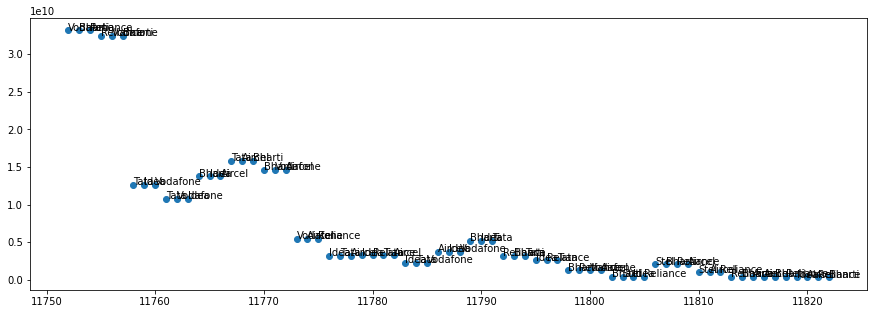

In [11]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,5))
# X axis : lotID
# Y axis : amount
plt.scatter(merged['lotId'], merged['amount'])

for i, winner in enumerate(merged['winner']):
  plt.annotate(winner, (merged['lotId'][i], merged['amount'][i]))

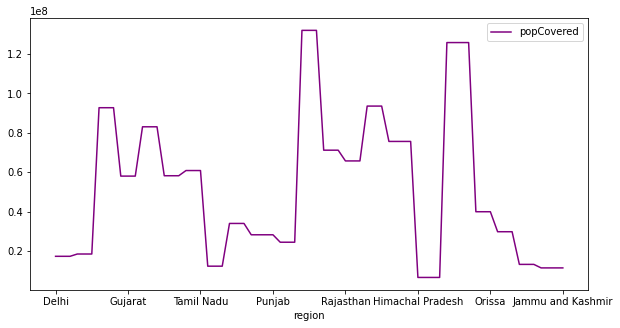

In [12]:
merged.plot(x='region', y='popCovered',figsize=(10,5),color='purple')

For each company as we have kind of 6 of them lets find out:
*   Number of wins
*   Total MOney Spend above reserved price
*   Average bids
*   Avg Winning bid over reserved 
*   Total population covered 
*   Overall population covered
*   Average population coved 
*   Regions


In [13]:
dict_for_Overall_Data = {"owner":[], "population":[], "average_population":[], "total_spend":[], "average_spend":[], "average_spend_over_reserve":[]}

In [14]:
def Get_Insights(For_Winner):
    # Prepare Variables
    Number_of_Wins = 0
    Total_Spend = int(0)
    Average_Biding_Price = 0
    Average_Biding_Price_Over_Reserved = 0
    Population_Coverd = 0
    Average_Population_Covered = 0
    Regions = set()

    for index, row in merged.iterrows():
        if row['winner'] == For_Winner:
            Number_of_Wins += 1
            Total_Spend += row['headlinePriceLocal']
            Average_Biding_Price_Over_Reserved +=  row['headlinePriceLocal'] -  row['reservePriceLocal']
            Population_Coverd += row['popCovered']
            Regions.add(row['region'])
    

    Average_Biding_Price = Total_Spend / Number_of_Wins
    Average_Biding_Price_Over_Reserved /= Number_of_Wins
    Average_Population_Covered = Population_Coverd / Number_of_Wins

    print(For_Winner)
    print("Won in ", Number_of_Wins, "  Bids") 
    print("Total Spend : ",Total_Spend)
    print("Average Bidding Price : ", round(Average_Biding_Price, 2))
    print("Average Bidding prie over Reserved : ", round(Average_Biding_Price_Over_Reserved, 2))
    print("Total population Coverd : ", Population_Coverd)
    dict_for_Overall_Data["owner"].append(For_Winner)
    dict_for_Overall_Data["population"].append(Population_Coverd)
    dict_for_Overall_Data["average_population"].append(round(Average_Population_Covered, 2))
    dict_for_Overall_Data["total_spend"].append(Total_Spend)
    dict_for_Overall_Data["average_spend"].append(round(Average_Biding_Price, 2))
    dict_for_Overall_Data["average_spend_over_reserve"].append(round(Average_Biding_Price_Over_Reserved, 2))
    print("Average Population Coverd : ", round(Average_Population_Covered, 2))
    print("Regions Coverd are : ", Regions)
    print("-----------------------------------------------------------------------------------------------------")
    #return dict_for_Population_Overall

In [15]:
# dict_for_Population_Overall = {"owner":[],"population":[]}
    
for winner in merged['winner'].unique():
    Get_Insights(winner)
    print("")

Vodafone
Won in  9   Bids
Total Spend :  116190000000.0
Average Bidding Price :  12910000000.0
Average Bidding prie over Reserved :  10598888888.89
Total population Coverd :  492143802.0
Average Population Coverd :  54682644.67
Regions Coverd are :  {'Mumbai', 'Maharashtra', 'Gujarat', 'Uttar Pradesh East', 'Delhi', 'Haryana', 'Tamil Nadu', 'Kolkata', 'West Bengal'}
-----------------------------------------------------------------------------------------------------

Bharti
Won in  13   Bids
Total Spend :  122940000000.0
Average Bidding Price :  9456923076.92
Average Bidding prie over Reserved :  7833846153.85
Total population Coverd :  637859819.0
Average Population Coverd :  49066139.92
Regions Coverd are :  {'Karnataka', 'Rajasthan', 'Mumbai', 'Uttar Pradesh West', 'Bihar', 'North East', 'Delhi', 'Jammu and Kashmir', 'Assam', 'Tamil Nadu', 'Himachal Pradesh', 'Andhra Pradesh', 'West Bengal'}
--------------------------------------------------------------------------------------------

In [16]:
print(dict_for_Overall_Data)

{'owner': ['Vodafone', 'Bharti', 'Reliance', 'Tata', 'Idea', 'Aircel', 'Stel'], 'population': [492143802.0, 637859819.0, 538758082.0, 526440126.0, 635650918.0, 704958746.0, 172433353.0], 'average_population': [54682644.67, 49066139.92, 41442929.38, 58493347.33, 57786447.09, 54227595.85, 57477784.33], 'total_spend': [116190000000.0, 122940000000.0, 85830000000.0, 58640000000.0, 57680000000.0, 64980000000.0, 3370000000.0], 'average_spend': [12910000000.0, 9456923076.92, 6602307692.31, 6515555555.56, 5243636363.64, 4998461538.46, 1123333333.33], 'average_spend_over_reserve': [10598888888.89, 7833846153.85, 5510000000.0, 4648888888.89, 3661818181.82, 3683076923.08, 823333333.33]}


### Plots


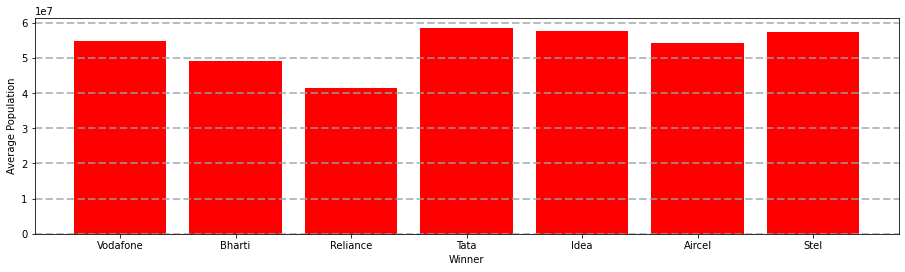

In [17]:
# Plot of Average population of each owner  
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['average_population']
ax.bar(langs,students,color='red')
plt.xlabel('Winner')
plt.ylabel('Average Population')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

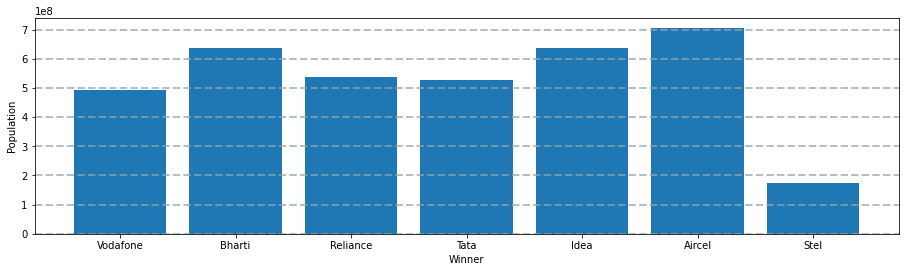

In [18]:
# Plot of Total population of each owner
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['population']
ax.bar(langs,students)
plt.xlabel('Winner')
plt.ylabel('Population')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

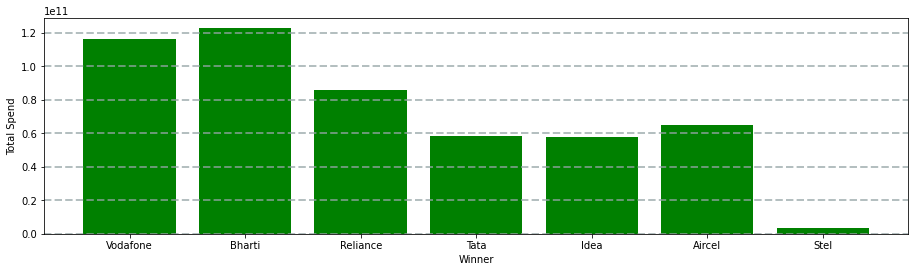

In [19]:
# Plot of total spending of each owner
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['total_spend']
ax.bar(langs,students,color='green')
plt.xlabel('Winner')
plt.ylabel('Total Spend')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

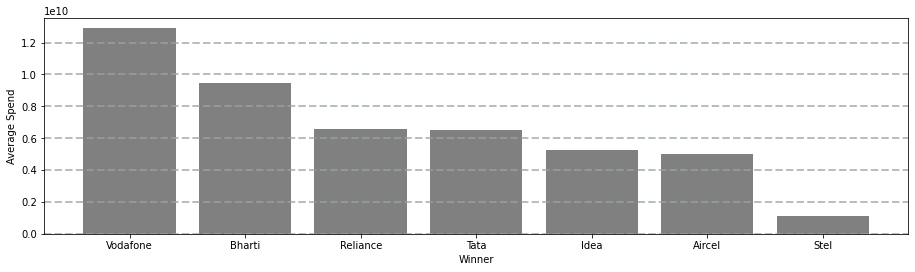

In [20]:
# plot of average spending of each ownerr  
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['average_spend']
ax.bar(langs,students,color='grey')
plt.xlabel('Winner')
plt.ylabel('Average Spend')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

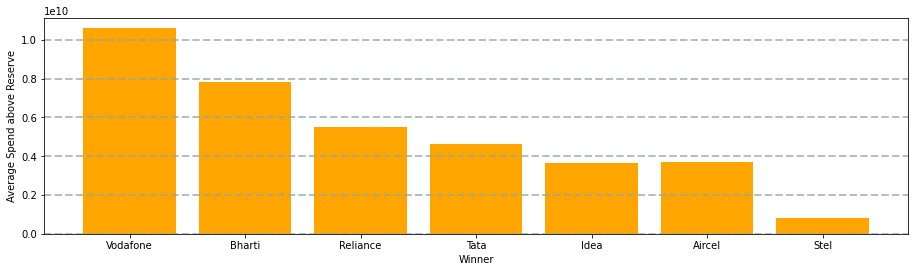

In [21]:
# plot of average spending over reserve  
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['average_spend_over_reserve']
ax.bar(langs,students,color='orange')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xlabel('Winner')
plt.ylabel('Average Spend above Reserve')
plt.show()

### Making dataframe compatible

In [22]:
# Model
# Remove column name 
merged.drop(['minAmount', 'amount'], axis = 1)

,awardId,lotId,awardName,countryName,alpha3code,nBidders,date,awardClassDescription,availableSpectrumPaired,availableSpectrumUnpaired,licenceUse,awardComments,lotName,winner,freqBand,nationalLicence,region,blockFreq,paired,unpaired,licenceDuration,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved,lotComments,year
0,242,11752,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi A,Vodafone,2.1GHz,0,Delhi,uplink: 1959-1964MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN,0.0
1,242,11753,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi B,Bharti,2.1GHz,0,Delhi,uplink: 1969-1974MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN,0.0
2,242,11754,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Delhi C,Reliance,2.1GHz,0,Delhi,uplink: 1974-1979MHz,10.0,0.0,20.0,17403916.0,3.200000e+09,3.317000e+10,0.0,NaN,0.0
3,242,11755,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Mumbai A,Reliance,2.1GHz,0,Mumbai,uplink: 1959-1964MHz,10.0,0.0,20.0,18571429.0,3.200000e+09,3.247000e+10,0.0,NaN,0.0
4,242,11756,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Mumbai B,Vodafone,2.1GHz,0,Mumbai,uplink: 1969-1974MHz,10.0,0.0,20.0,18571429.0,3.200000e+09,3.247000e+10,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,242,11818,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,North East C,Reliance,2.1GHz,0,North East,uplink: 1974-1979MHz,10.0,0.0,20.0,13310581.0,3.000000e+08,4.200000e+08,0.0,NaN,0.0
67,242,11819,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Jammu and Kashmir A,Idea,2.1GHz,0,Jammu and Kashmir,uplink: 1959-1964MHz,10.0,0.0,20.0,11528151.0,3.000000e+08,3.000000e+08,0.0,NaN,0.0
68,242,11820,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Jammu and Kashmir B,Aircel,2.1GHz,0,Jammu and Kashmir,uplink: 1964-1969MHz,10.0,0.0,20.0,11528151.0,3.000000e+08,3.000000e+08,0.0,NaN,0.0
69,242,11821,3G auction,India,IND,9.0,2010-05-19,Auction - Largely standard clock,710.0,0.0,neutral,NaN,Jammu and Kashmir C,Reliance,2.1GHz,0,Jammu and Kashmir,uplink: 1969-1974MHz,10.0,0.0,20.0,11528151.0,3.000000e+08,3.000000e+08,0.0,NaN,0.0


### Handle Null Values


In [23]:
# Handle Nulls
merged_cols = merged.columns.to_list()
mv = merged[merged_cols].isnull().sum()
mp = mv / len(merged)*100
mp

awardId                        0.0
lotId                          0.0
awardName                      0.0
countryName                    0.0
alpha3code                     0.0
nBidders                       0.0
date                           0.0
awardClassDescription          0.0
availableSpectrumPaired        0.0
availableSpectrumUnpaired      0.0
licenceUse                     0.0
awardComments                100.0
lotName                        0.0
winner                         0.0
freqBand                       0.0
nationalLicence                0.0
region                         0.0
blockFreq                      0.0
paired                         0.0
unpaired                       0.0
licenceDuration                0.0
popCovered                     0.0
reservePriceLocal              0.0
headlinePriceLocal             0.0
entrantReserved                0.0
lotComments                  100.0
year                           0.0
amount                         0.0
minAmount           

In [24]:
# Drop columns with null values
merged = merged.drop(['lotComments', 'awardComments'], axis = 1)

In [25]:
# Delete columns which have only one or null values overall
for col in merged.columns.to_list():
    count = merged[col].nunique()
    if count == 1:
        del merged[col]
merged

,lotId,lotName,winner,region,blockFreq,popCovered,reservePriceLocal,headlinePriceLocal,amount,minAmount
0,11752,Delhi A,Vodafone,Delhi,uplink: 1959-1964MHz,17403916.0,3.200000e+09,3.317000e+10,3.317000e+10,3.200000e+09
1,11753,Delhi B,Bharti,Delhi,uplink: 1969-1974MHz,17403916.0,3.200000e+09,3.317000e+10,3.317000e+10,3.200000e+09
2,11754,Delhi C,Reliance,Delhi,uplink: 1974-1979MHz,17403916.0,3.200000e+09,3.317000e+10,3.317000e+10,3.200000e+09
3,11755,Mumbai A,Reliance,Mumbai,uplink: 1959-1964MHz,18571429.0,3.200000e+09,3.247000e+10,3.247000e+10,3.200000e+09
4,11756,Mumbai B,Vodafone,Mumbai,uplink: 1969-1974MHz,18571429.0,3.200000e+09,3.247000e+10,3.247000e+10,3.200000e+09
...,...,...,...,...,...,...,...,...,...,...
66,11818,North East C,Reliance,North East,uplink: 1974-1979MHz,13310581.0,3.000000e+08,4.200000e+08,4.200000e+08,3.000000e+08
67,11819,Jammu and Kashmir A,Idea,Jammu and Kashmir,uplink: 1959-1964MHz,11528151.0,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08
68,11820,Jammu and Kashmir B,Aircel,Jammu and Kashmir,uplink: 1964-1969MHz,11528151.0,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08
69,11821,Jammu and Kashmir C,Reliance,Jammu and Kashmir,uplink: 1969-1974MHz,11528151.0,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08


In [26]:
'''
# Label Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

merged['lotName'] = LabelEncoder().fit_transform(merged.lotName)
merged['winner'] = LabelEncoder().fit_transform(merged.winner)
merged['region'] = LabelEncoder().fit_transform(merged.region)
merged['blockFreq'] = LabelEncoder().fit_transform(merged.blockFreq)

merged
# One Hot Encoding
ohc = OneHotEncoder()
ohe = ohc.fit_transform(merged.winner.value.reshape(-1, 1)).to_array()
mergedOHE = pd.Dataframe(ohe, columns = ["Winner_" +str(ohc.categories[0][i])
                                                    for i in range(len(ohc.categories_[0]))])
mergedOHE = pd.concat([merged, mergedOHE], axis = 1)
merged
'''

'\n# Label Encoding\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.preprocessing import OneHotEncoder\n\nmerged[\'lotName\'] = LabelEncoder().fit_transform(merged.lotName)\nmerged[\'winner\'] = LabelEncoder().fit_transform(merged.winner)\nmerged[\'region\'] = LabelEncoder().fit_transform(merged.region)\nmerged[\'blockFreq\'] = LabelEncoder().fit_transform(merged.blockFreq)\n\nmerged\n# One Hot Encoding\nohc = OneHotEncoder()\nohe = ohc.fit_transform(merged.winner.value.reshape(-1, 1)).to_array()\nmergedOHE = pd.Dataframe(ohe, columns = ["Winner_" +str(ohc.categories[0][i])\n                                                    for i in range(len(ohc.categories_[0]))])\nmergedOHE = pd.concat([merged, mergedOHE], axis = 1)\nmerged\n'

In [27]:
t = merged.corr()
t 

,lotId,popCovered,reservePriceLocal,headlinePriceLocal,amount,minAmount
lotId,1.000000,-0.054133,-0.911823,-0.793653,-0.793653,-0.911823
popCovered,-0.054133,1.000000,0.127851,-0.096129,-0.096129,0.127851
reservePriceLocal,-0.911823,0.127851,1.000000,0.828801,0.828801,1.000000
headlinePriceLocal,-0.793653,-0.096129,0.828801,1.000000,1.000000,0.828801
amount,-0.793653,-0.096129,0.828801,1.000000,1.000000,0.828801
minAmount,-0.911823,0.127851,1.000000,0.828801,0.828801,1.000000


### Frequency Encoding

In [28]:
# Frequency Encoding
def Frequency_Encode(col):
    # print(col)
    fe = merged.groupby(col).size() / len(merged)
    merged.loc[:, col + '_freq_encode'] = merged[col].map(fe)
    merged

for col in merged.columns.to_list():
    # print(col, type(merged[col]))
    if merged[col].dtype == 'object':
        Frequency_Encode(col)
        del merged[col]

merged

,lotId,popCovered,reservePriceLocal,headlinePriceLocal,amount,minAmount,lotName_freq_encode,winner_freq_encode,region_freq_encode,blockFreq_freq_encode
0,11752,17403916.0,3.200000e+09,3.317000e+10,3.317000e+10,3.200000e+09,0.014085,0.126761,0.042254,0.309859
1,11753,17403916.0,3.200000e+09,3.317000e+10,3.317000e+10,3.200000e+09,0.014085,0.183099,0.042254,0.309859
2,11754,17403916.0,3.200000e+09,3.317000e+10,3.317000e+10,3.200000e+09,0.014085,0.183099,0.042254,0.309859
3,11755,18571429.0,3.200000e+09,3.247000e+10,3.247000e+10,3.200000e+09,0.014085,0.183099,0.042254,0.309859
4,11756,18571429.0,3.200000e+09,3.247000e+10,3.247000e+10,3.200000e+09,0.014085,0.126761,0.042254,0.309859
...,...,...,...,...,...,...,...,...,...,...
66,11818,13310581.0,3.000000e+08,4.200000e+08,4.200000e+08,3.000000e+08,0.014085,0.183099,0.042254,0.309859
67,11819,11528151.0,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,0.014085,0.154930,0.056338,0.309859
68,11820,11528151.0,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,0.014085,0.183099,0.056338,0.070423
69,11821,11528151.0,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,0.014085,0.183099,0.056338,0.309859


In [29]:
x = merged.copy()
del x['amount']
del x['minAmount']
# del x['headlinePriceLocal']
y = pd.DataFrame(merged.headlinePriceLocal)
x

,lotId,popCovered,reservePriceLocal,headlinePriceLocal,lotName_freq_encode,winner_freq_encode,region_freq_encode,blockFreq_freq_encode
0,11752,17403916.0,3.200000e+09,3.317000e+10,0.014085,0.126761,0.042254,0.309859
1,11753,17403916.0,3.200000e+09,3.317000e+10,0.014085,0.183099,0.042254,0.309859
2,11754,17403916.0,3.200000e+09,3.317000e+10,0.014085,0.183099,0.042254,0.309859
3,11755,18571429.0,3.200000e+09,3.247000e+10,0.014085,0.183099,0.042254,0.309859
4,11756,18571429.0,3.200000e+09,3.247000e+10,0.014085,0.126761,0.042254,0.309859
...,...,...,...,...,...,...,...,...
66,11818,13310581.0,3.000000e+08,4.200000e+08,0.014085,0.183099,0.042254,0.309859
67,11819,11528151.0,3.000000e+08,3.000000e+08,0.014085,0.154930,0.056338,0.309859
68,11820,11528151.0,3.000000e+08,3.000000e+08,0.014085,0.183099,0.056338,0.070423
69,11821,11528151.0,3.000000e+08,3.000000e+08,0.014085,0.183099,0.056338,0.309859


In [30]:
y

,headlinePriceLocal
0,3.317000e+10
1,3.317000e+10
2,3.317000e+10
3,3.247000e+10
4,3.247000e+10
...,...
66,4.200000e+08
67,3.000000e+08
68,3.000000e+08
69,3.000000e+08


In [31]:
print(x.shape, y.shape)

(71, 8) (71, 1)


### Correlarion Matrix

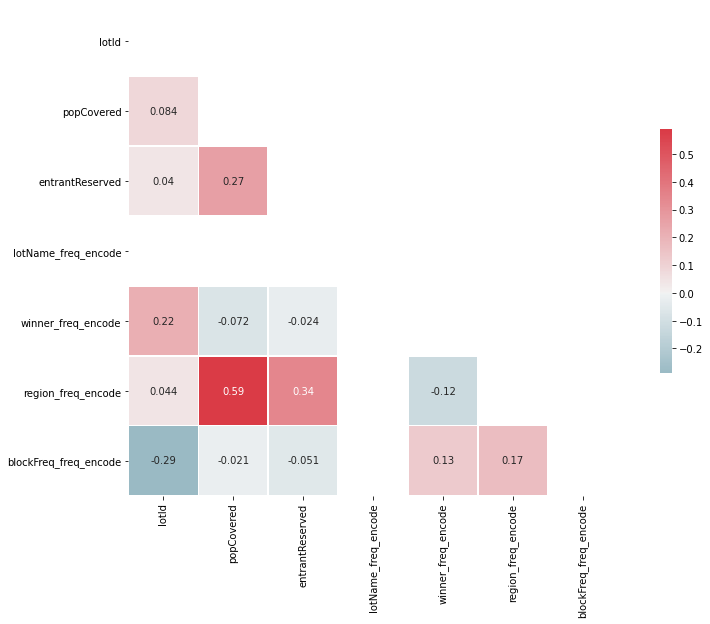

In [103]:
# Compute the correlation matrix
corr = x.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Model

In [33]:
# x has train
# y has target var
del x['headlinePriceLocal']

train_dataset = cb.Pool(x, y)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [150, 200, 300],
        'learning_rate': [0.1],
        'depth': [8, 10, 15],
        'l2_leaf_reg': [3, 5]}
model.grid_search(grid, train_dataset)


0:	learn: 11460052192.1213551	test: 8117986814.6076860	best: 8117986814.6076860 (0)	total: 46.3ms	remaining: 6.9s
1:	learn: 10852720155.3613491	test: 7707122740.4471855	best: 7707122740.4471855 (1)	total: 47.5ms	remaining: 3.52s
2:	learn: 10119937672.6118164	test: 6737413660.9206495	best: 6737413660.9206495 (2)	total: 48.1ms	remaining: 2.36s
3:	learn: 9460424699.6803589	test: 5851343379.9670143	best: 5851343379.9670143 (3)	total: 48.6ms	remaining: 1.77s
4:	learn: 9042643259.5714493	test: 5598508577.3304348	best: 5598508577.3304348 (4)	total: 49.8ms	remaining: 1.44s
5:	learn: 8460597797.4619560	test: 5329974277.8308458	best: 5329974277.8308458 (5)	total: 50.4ms	remaining: 1.21s
6:	learn: 7978069810.3219242	test: 4629131359.1771679	best: 4629131359.1771679 (6)	total: 51.2ms	remaining: 1.05s
7:	learn: 7461084731.0788383	test: 4356863759.3698807	best: 4356863759.3698807 (7)	total: 52.2ms	remaining: 926ms
8:	learn: 6992423621.5532408	test: 4002077127.7145019	best: 4002077127.7145019 (8)	tot

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [34]:
pred = model.predict(x)
rmse = (np.sqrt(mean_squared_error(y, pred)))
r2 = r2_score(y, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 75049867.48
R2: 1.00


Text(0.5, 0, 'CatBoost Feature Importance')

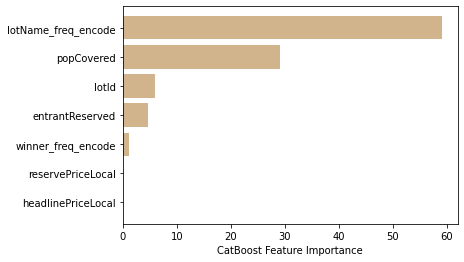

In [107]:
sorted_feature_importance = model.feature_importances_.argsort()
'''
print(type(sorted_feature_importance))
print(type(merged))
print(type(x))
print(type(y))

df = pd.DataFrame(merged.data,columns=merged.feature_names)
df['target'] = pd.Series(merged.headlinePriceLocal)
'''

plt.barh(merged.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='tan')
plt.xlabel("CatBoost Feature Importance") 



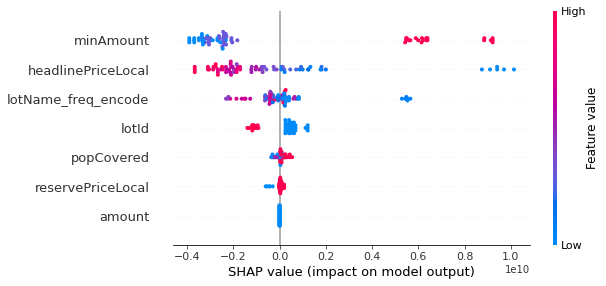

In [36]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x, feature_names = merged.columns[sorted_feature_importance])


# India 4G

In [37]:
merged = df_4G

merged

,awardId,lotId,awardName,countryName,alpha3code,nBidders,date,awardClassDescription,availableSpectrumPaired,availableSpectrumUnpaired,licenceUse,awardComments,lotName,winner,freqBand,nationalLicence,region,blockFreq,paired,unpaired,licenceDuration,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved,lotComments
12578,338,12688,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 1,Sistema Shyam TeleServices Limited,800MHz,0,Delhi,840.975-842.205MHz/885.975-887.205MHz,2.46,0.0,20.0,16753235.0,4.504900e+09,4.504900e+09,0.0,Population figures taken from the 2011 Indian ...
12579,338,12689,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 2,Sistema Shyam TeleServices Limited,800MHz,0,Delhi,842.205-843.435MHz/887.205-888.435MHz,2.46,0.0,20.0,16753235.0,4.504900e+09,4.504900e+09,0.0,Population figures taken from the 2011 Indian ...
12580,338,12690,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 3,Sistema Shyam TeleServices Limited,800MHz,0,Delhi,828.405-829.635MHz/873.405-874.635MHz,2.46,0.0,20.0,16753235.0,4.504900e+09,4.504900e+09,0.0,Population figures taken from the 2011 Indian ...
12581,338,12691,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 1,Sistema Shyam TeleServices Limited,800MHz,0,Gujarat,827.175-828.405MHz/872.175-873.405MHz,2.46,0.0,20.0,60383628.0,1.461500e+09,1.461500e+09,0.0,Population figures taken from the 2011 Indian ...
12582,338,12692,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 2,Sistema Shyam TeleServices Limited,800MHz,0,Gujarat,828.405-829.635MHz/873.405-874.635MHz,2.46,0.0,20.0,60383628.0,1.461500e+09,1.461500e+09,0.0,Population figures taken from the 2011 Indian ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12561,335,12670,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Delhi 900 Vodafone,Vodafone,900MHz,0,Delhi,895.1-899.1MHz/896.1-900.1MHz,10.00,0.0,20.0,16753235.0,1.800000e+10,3.704800e+10,0.0,Population figures based on the 2011 Indian po...
12562,335,12671,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Kolkata 900 Bharti,Bharti,900MHz,0,Kolkata,895.1-899.1MHz/896.1-900.1MHz & 909.5-910.5MHz...,14.00,0.0,20.0,14112536.0,8.750000e+09,1.362410e+10,0.0,Population figures based on the 2011 Indian po...
12563,335,12672,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Kolkata 900 Vodafone,Vodafone,900MHz,0,Kolkata,890.1-894.1MHz/891.1-895.1MHz & 900.1-901.1MHz...,14.00,0.0,20.0,14112536.0,8.750000e+09,1.362410e+10,0.0,Population figures based on the 2011 Indian po...
12564,335,12673,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Mumbai 900 Bharti,Bharti,900MHz,0,Mumbai,909.9-913.9MHz/910.9-914.9MHz,10.00,0.0,20.0,18414288.0,1.640000e+10,2.815450e+10,0.0,Population figures based on the 2011 Indian po...


In [38]:
merged['awardName'].unique()

array(['India 800MHz', 'India 800MHz, 900MHz, 1800MHz and 2100MHz',
       'India 900MHz & 1800MHz'], dtype=object)

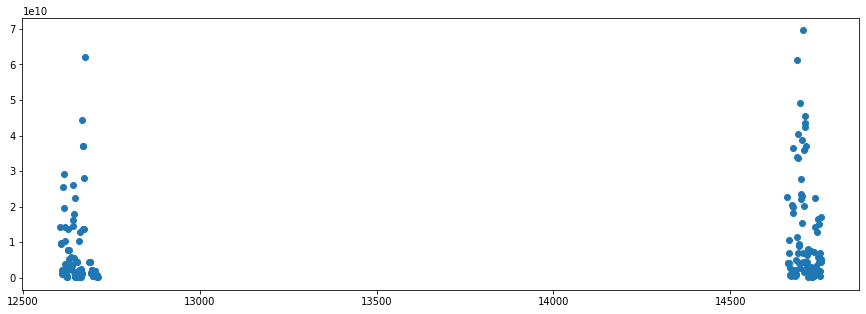

In [39]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,5))
# X axis : lotID
# Y axis : amount
plt.scatter(merged['lotId'], merged['headlinePriceLocal'])

#for i, winner in enumerate(merged['winner']):
#  plt.annotate(winner, (merged['lotId'][i], merged['reservePriceLocal'][i]))

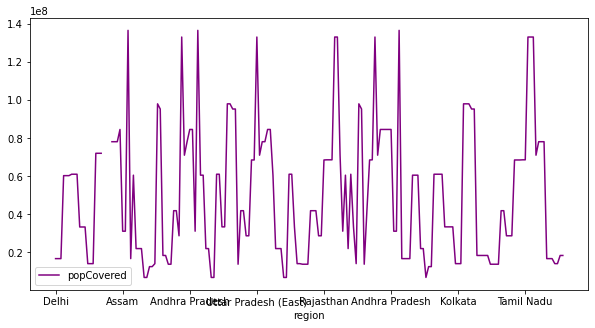

In [40]:
merged.plot(x='region', y='popCovered',figsize=(10,5),color='purple')

For each company as we have kind of 6 of them lets find out:
*   Number of wins
*   Total MOney Spend above reserved price
*   Average bids
*   Avg Winning bid over reserved 
*   Total population covered 
*   Overall population covered
*   Average population coved 
*   Regions


In [41]:
dict_for_Overall_Data = {"owner":[], "population":[], "average_population":[], "total_spend":[], "average_spend":[], "average_spend_over_reserve":[]}

In [42]:
def Get_Insights(For_Winner):
    # Prepare Variables
    Number_of_Wins = 0
    Total_Spend = int(0)
    Average_Biding_Price = 0
    Average_Biding_Price_Over_Reserved = 0
    Population_Coverd = 0
    Average_Population_Covered = 0
    Regions = set()

    for index, row in merged.iterrows():
        if row['winner'] == For_Winner:
            Number_of_Wins += 1
            Total_Spend += row['headlinePriceLocal']
            Average_Biding_Price_Over_Reserved +=  row['headlinePriceLocal'] -  row['reservePriceLocal']
            Population_Coverd += row['popCovered']
            Regions.add(row['region'])
    

    Average_Biding_Price = Total_Spend / Number_of_Wins
    Average_Biding_Price_Over_Reserved /= Number_of_Wins
    Average_Population_Covered = Population_Coverd / Number_of_Wins

    print(For_Winner)
    print("Won in ", Number_of_Wins, "  Bids") 
    print("Total Spend : ",Total_Spend)
    print("Average Bidding Price : ", round(Average_Biding_Price, 2))
    print("Average Bidding prie over Reserved : ", round(Average_Biding_Price_Over_Reserved, 2))
    print("Total population Coverd : ", Population_Coverd)
    dict_for_Overall_Data["owner"].append(For_Winner)
    dict_for_Overall_Data["population"].append(Population_Coverd)
    dict_for_Overall_Data["average_population"].append(round(Average_Population_Covered, 2))
    dict_for_Overall_Data["total_spend"].append(Total_Spend)
    dict_for_Overall_Data["average_spend"].append(round(Average_Biding_Price, 2))
    dict_for_Overall_Data["average_spend_over_reserve"].append(round(Average_Biding_Price_Over_Reserved, 2))
    print("Average Population Coverd : ", round(Average_Population_Covered, 2))
    print("Regions Coverd are : ", Regions)
    print("-----------------------------------------------------------------------------------------------------")
    #return dict_for_Population_Overall

In [43]:
# dict_for_Population_Overall = {"owner":[],"population":[]}
    
for winner in merged['winner'].unique():
    Get_Insights(winner)
    print("")

Sistema Shyam TeleServices Limited
Won in  24   Bids
Total Spend :  36394800000.0
Average Bidding Price :  1516450000.0
Average Bidding prie over Reserved :  0.0
Total population Coverd :  nan
Average Population Coverd :  nan
Regions Coverd are :  {'Karnataka', 'Gujarat', 'Delhi', 'Uttar Pradesh (West)', 'Tamil Nadu', 'Kolkata', 'Kerela', 'West Bengal'}
-----------------------------------------------------------------------------------------------------

Tata
Won in  6   Bids
Total Spend :  78513300000.0
Average Bidding Price :  13085550000.0
Average Bidding prie over Reserved :  6284466666.67
Total population Coverd :  321944459.0
Average Population Coverd :  53657409.83
Regions Coverd are :  {'Mumbai', 'Maharashtra', 'Delhi', 'Haryana', 'Andhra Pradesh'}
-----------------------------------------------------------------------------------------------------

RCOM
Won in  19   Bids
Total Spend :  44623300000.0
Average Bidding Price :  2348594736.84
Average Bidding prie over Reserved :  6

In [44]:
print(dict_for_Overall_Data)

{'owner': ['Sistema Shyam TeleServices Limited', 'Tata', 'RCOM', 'RJIO', 'Bharti', 'Idea', 'Vodafone', 'Aircel', 'RJIL', 'Telewings'], 'population': [nan, 321944459.0, 672300539.0, 828533855.0, 1972817137.0, 1382989380.0, 1631343797.0, 375169390.0, 716561928.0, 457000076.0], 'average_population': [nan, 53657409.83, 35384238.89, 51783365.94, 48117491.15, 49392477.86, 52623993.45, 62528231.67, 51182994.86, 91400015.2], 'total_spend': [36394800000.0, 78513300000.0, 44623300000.0, 100775300000.0, 476598400000.0, 410226100000.0, 455960100000.0, 24599000000.0, 110544100000.0, 8447200000.0], 'average_spend': [1516450000.0, 13085550000.0, 2348594736.84, 6298456250.0, 11624351219.51, 14650932142.86, 14708390322.58, 4099833333.33, 7896007142.86, 1689440000.0], 'average_spend_over_reserve': [0.0, 6284466666.67, 686357894.74, 2576518750.0, 4031082926.83, 5605575000.0, 6164132258.06, 19500000.0, 1851578571.43, 518640000.0]}


### Plots

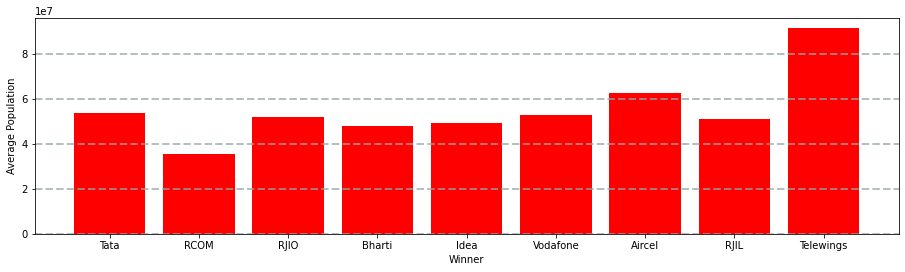

In [45]:
# Plot of Average population of each owner  
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['average_population']
ax.bar(langs,students,color='red')
plt.xlabel('Winner')
plt.ylabel('Average Population')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

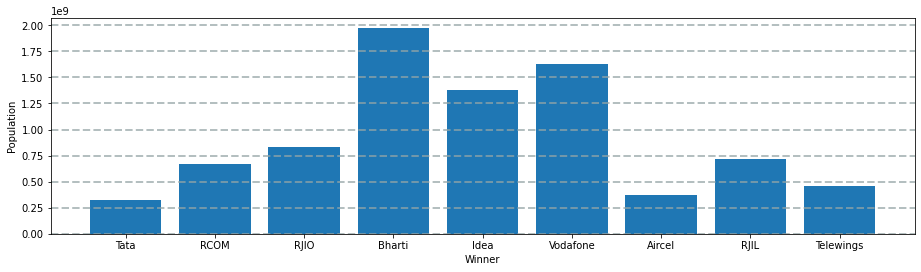

In [46]:
# Plot of Total population of each owner
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['population']
ax.bar(langs,students)
plt.xlabel('Winner')
plt.ylabel('Population')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

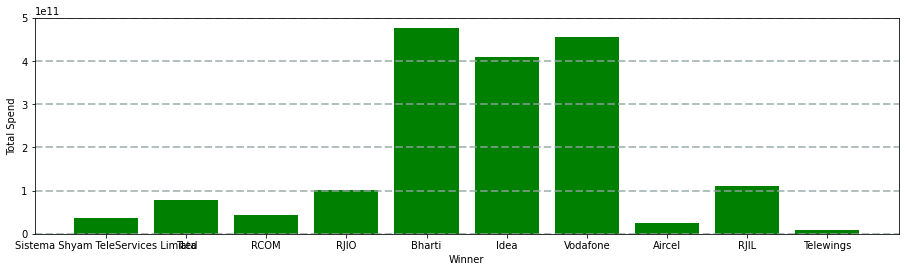

In [47]:
# Plot of total spending of each owner
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['total_spend']
ax.bar(langs,students,color='green')
plt.xlabel('Winner')
plt.ylabel('Total Spend')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

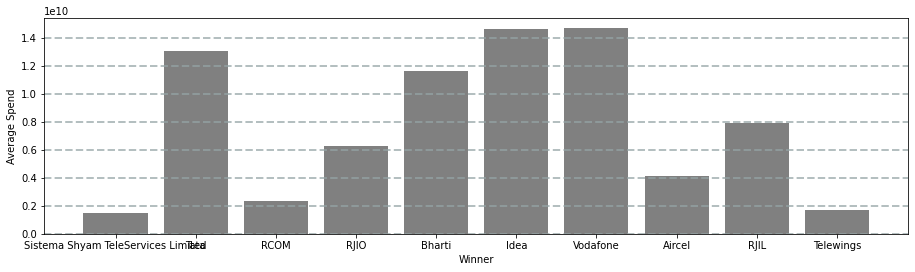

In [48]:
# plot of average spending of each ownerr  
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['average_spend']
ax.bar(langs,students,color='grey')
plt.xlabel('Winner')
plt.ylabel('Average Spend')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

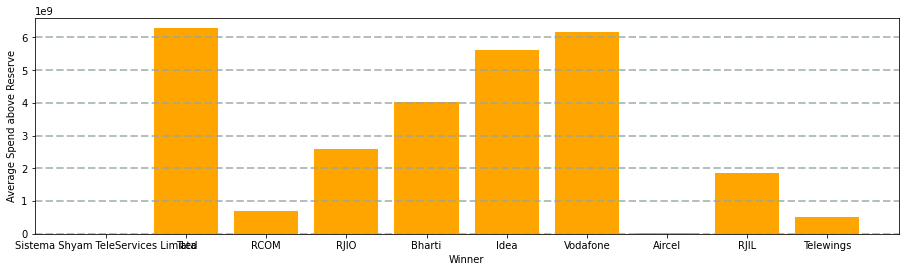

In [49]:
# plot of average spending over reserve  
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['average_spend_over_reserve']
ax.bar(langs,students,color='orange')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xlabel('Winner')
plt.ylabel('Average Spend above Reserve')
plt.show()

### Making dataframe compatible

In [50]:
# Model
# Remove column name 
merged.drop(['reservePriceLocal', 'headlinePriceLocal'], axis = 1)

,awardId,lotId,awardName,countryName,alpha3code,nBidders,date,awardClassDescription,availableSpectrumPaired,availableSpectrumUnpaired,licenceUse,awardComments,lotName,winner,freqBand,nationalLicence,region,blockFreq,paired,unpaired,licenceDuration,popCovered,entrantReserved,lotComments
12578,338,12688,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 1,Sistema Shyam TeleServices Limited,800MHz,0,Delhi,840.975-842.205MHz/885.975-887.205MHz,2.46,0.0,20.0,16753235.0,0.0,Population figures taken from the 2011 Indian ...
12579,338,12689,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 2,Sistema Shyam TeleServices Limited,800MHz,0,Delhi,842.205-843.435MHz/887.205-888.435MHz,2.46,0.0,20.0,16753235.0,0.0,Population figures taken from the 2011 Indian ...
12580,338,12690,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 3,Sistema Shyam TeleServices Limited,800MHz,0,Delhi,828.405-829.635MHz/873.405-874.635MHz,2.46,0.0,20.0,16753235.0,0.0,Population figures taken from the 2011 Indian ...
12581,338,12691,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 1,Sistema Shyam TeleServices Limited,800MHz,0,Gujarat,827.175-828.405MHz/872.175-873.405MHz,2.46,0.0,20.0,60383628.0,0.0,Population figures taken from the 2011 Indian ...
12582,338,12692,India 800MHz,India,IND,1.0,2013-03-11,Auction - Largely standard clock,190.0,0.0,mobile,This was the re-auction of the unsold 800MHz a...,Block 2,Sistema Shyam TeleServices Limited,800MHz,0,Gujarat,828.405-829.635MHz/873.405-874.635MHz,2.46,0.0,20.0,60383628.0,0.0,Population figures taken from the 2011 Indian ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12561,335,12670,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Delhi 900 Vodafone,Vodafone,900MHz,0,Delhi,895.1-899.1MHz/896.1-900.1MHz,10.00,0.0,20.0,16753235.0,0.0,Population figures based on the 2011 Indian po...
12562,335,12671,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Kolkata 900 Bharti,Bharti,900MHz,0,Kolkata,895.1-899.1MHz/896.1-900.1MHz & 909.5-910.5MHz...,14.00,0.0,20.0,14112536.0,0.0,Population figures based on the 2011 Indian po...
12563,335,12672,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Kolkata 900 Vodafone,Vodafone,900MHz,0,Kolkata,890.1-894.1MHz/891.1-895.1MHz & 900.1-901.1MHz...,14.00,0.0,20.0,14112536.0,0.0,Population figures based on the 2011 Indian po...
12564,335,12673,India 900MHz & 1800MHz,India,IND,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,0.0,neutral,"Auction format: SMRA with small block sizes, s...",Mumbai 900 Bharti,Bharti,900MHz,0,Mumbai,909.9-913.9MHz/910.9-914.9MHz,10.00,0.0,20.0,18414288.0,0.0,Population figures based on the 2011 Indian po...


### Handling Null VAlues

In [51]:
# Handle Nulls
merged_cols = merged.columns.to_list()
mv = merged[merged_cols].isnull().sum()
mp = mv / len(merged)*100
mp

awardId                      0.000000
lotId                        0.000000
awardName                    0.000000
countryName                  0.000000
alpha3code                   0.000000
nBidders                     0.000000
date                         0.000000
awardClassDescription        0.000000
availableSpectrumPaired      0.000000
availableSpectrumUnpaired    0.000000
licenceUse                   0.000000
awardComments                0.000000
lotName                      0.000000
winner                       0.000000
freqBand                     0.000000
nationalLicence              0.000000
region                       0.000000
blockFreq                    0.000000
paired                       0.000000
unpaired                     0.000000
licenceDuration              0.000000
popCovered                   1.578947
reservePriceLocal            0.000000
headlinePriceLocal           0.000000
entrantReserved              0.000000
lotComments                  0.000000
dtype: float

In [52]:
# Drop columns with null values
merged = merged.drop(['lotComments', 'awardComments'], axis = 1)

In [53]:
# Delete columns which have only one or null values overall
for col in merged.columns.to_list():
    count = merged[col].nunique()
    if count == 1:
        del merged[col]
merged

,awardId,lotId,awardName,nBidders,date,awardClassDescription,availableSpectrumPaired,licenceUse,lotName,winner,freqBand,region,blockFreq,paired,popCovered,reservePriceLocal,headlinePriceLocal
12578,338,12688,India 800MHz,1.0,2013-03-11,Auction - Largely standard clock,190.0,mobile,Block 1,Sistema Shyam TeleServices Limited,800MHz,Delhi,840.975-842.205MHz/885.975-887.205MHz,2.46,16753235.0,4.504900e+09,4.504900e+09
12579,338,12689,India 800MHz,1.0,2013-03-11,Auction - Largely standard clock,190.0,mobile,Block 2,Sistema Shyam TeleServices Limited,800MHz,Delhi,842.205-843.435MHz/887.205-888.435MHz,2.46,16753235.0,4.504900e+09,4.504900e+09
12580,338,12690,India 800MHz,1.0,2013-03-11,Auction - Largely standard clock,190.0,mobile,Block 3,Sistema Shyam TeleServices Limited,800MHz,Delhi,828.405-829.635MHz/873.405-874.635MHz,2.46,16753235.0,4.504900e+09,4.504900e+09
12581,338,12691,India 800MHz,1.0,2013-03-11,Auction - Largely standard clock,190.0,mobile,Block 1,Sistema Shyam TeleServices Limited,800MHz,Gujarat,827.175-828.405MHz/872.175-873.405MHz,2.46,60383628.0,1.461500e+09,1.461500e+09
12582,338,12692,India 800MHz,1.0,2013-03-11,Auction - Largely standard clock,190.0,mobile,Block 2,Sistema Shyam TeleServices Limited,800MHz,Gujarat,828.405-829.635MHz/873.405-874.635MHz,2.46,60383628.0,1.461500e+09,1.461500e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12561,335,12670,India 900MHz & 1800MHz,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,neutral,Delhi 900 Vodafone,Vodafone,900MHz,Delhi,895.1-899.1MHz/896.1-900.1MHz,10.00,16753235.0,1.800000e+10,3.704800e+10
12562,335,12671,India 900MHz & 1800MHz,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,neutral,Kolkata 900 Bharti,Bharti,900MHz,Kolkata,895.1-899.1MHz/896.1-900.1MHz & 909.5-910.5MHz...,14.00,14112536.0,8.750000e+09,1.362410e+10
12563,335,12672,India 900MHz & 1800MHz,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,neutral,Kolkata 900 Vodafone,Vodafone,900MHz,Kolkata,890.1-894.1MHz/891.1-895.1MHz & 900.1-901.1MHz...,14.00,14112536.0,8.750000e+09,1.362410e+10
12564,335,12673,India 900MHz & 1800MHz,8.0,2014-02-13,Auction - Largely standard SMRA,862.4,neutral,Mumbai 900 Bharti,Bharti,900MHz,Mumbai,909.9-913.9MHz/910.9-914.9MHz,10.00,18414288.0,1.640000e+10,2.815450e+10


In [54]:
'''
# Label Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

merged['lotName'] = LabelEncoder().fit_transform(merged.lotName)
merged['winner'] = LabelEncoder().fit_transform(merged.winner)
merged['region'] = LabelEncoder().fit_transform(merged.region)
merged['blockFreq'] = LabelEncoder().fit_transform(merged.blockFreq)

merged
# One Hot Encoding
ohc = OneHotEncoder()
ohe = ohc.fit_transform(merged.winner.value.reshape(-1, 1)).to_array()
mergedOHE = pd.Dataframe(ohe, columns = ["Winner_" +str(ohc.categories[0][i])
                                                    for i in range(len(ohc.categories_[0]))])
mergedOHE = pd.concat([merged, mergedOHE], axis = 1)
merged
'''

'\n# Label Encoding\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.preprocessing import OneHotEncoder\n\nmerged[\'lotName\'] = LabelEncoder().fit_transform(merged.lotName)\nmerged[\'winner\'] = LabelEncoder().fit_transform(merged.winner)\nmerged[\'region\'] = LabelEncoder().fit_transform(merged.region)\nmerged[\'blockFreq\'] = LabelEncoder().fit_transform(merged.blockFreq)\n\nmerged\n# One Hot Encoding\nohc = OneHotEncoder()\nohe = ohc.fit_transform(merged.winner.value.reshape(-1, 1)).to_array()\nmergedOHE = pd.Dataframe(ohe, columns = ["Winner_" +str(ohc.categories[0][i])\n                                                    for i in range(len(ohc.categories_[0]))])\nmergedOHE = pd.concat([merged, mergedOHE], axis = 1)\nmerged\n'

In [55]:
t = merged.corr()
t 

,awardId,lotId,nBidders,availableSpectrumPaired,paired,popCovered,reservePriceLocal,headlinePriceLocal
awardId,1.000000,0.999380,0.346914,0.468779,0.014502,0.050786,0.106797,0.157635
lotId,0.999380,1.000000,0.371827,0.492155,0.027979,0.052828,0.111831,0.161529
nBidders,0.346914,0.371827,1.000000,0.991085,0.443251,0.021280,0.213045,0.221589
availableSpectrumPaired,0.468779,0.492155,0.991085,1.000000,0.419516,0.027611,0.215817,0.231087
paired,0.014502,0.027979,0.443251,0.419516,1.000000,-0.067742,0.547300,0.515177
popCovered,0.050786,0.052828,0.021280,0.027611,-0.067742,1.000000,0.136086,0.122802
reservePriceLocal,0.106797,0.111831,0.213045,0.215817,0.547300,0.136086,1.000000,0.929594
headlinePriceLocal,0.157635,0.161529,0.221589,0.231087,0.515177,0.122802,0.929594,1.000000


### Frequency Encoding

In [56]:
# Frequency Encoding
def Frequency_Encode(col):
    # print(col)
    fe = merged.groupby(col).size() / len(merged)
    merged.loc[:, col + '_freq_encode'] = merged[col].map(fe)
    merged

for col in merged.columns.to_list():
    # print(col, type(merged[col]))
    if merged[col].dtype == 'object':
        Frequency_Encode(col)
        del merged[col]

merged

,awardId,lotId,nBidders,date,availableSpectrumPaired,paired,popCovered,reservePriceLocal,headlinePriceLocal,awardName_freq_encode,awardClassDescription_freq_encode,licenceUse_freq_encode,lotName_freq_encode,winner_freq_encode,freqBand_freq_encode,region_freq_encode,blockFreq_freq_encode
12578,338,12688,1.0,2013-03-11,190.0,2.46,16753235.0,4.504900e+09,4.504900e+09,0.126316,0.126316,0.126316,0.042105,0.126316,0.263158,0.057895,0.021053
12579,338,12689,1.0,2013-03-11,190.0,2.46,16753235.0,4.504900e+09,4.504900e+09,0.126316,0.126316,0.126316,0.042105,0.126316,0.263158,0.057895,0.026316
12580,338,12690,1.0,2013-03-11,190.0,2.46,16753235.0,4.504900e+09,4.504900e+09,0.126316,0.126316,0.126316,0.042105,0.126316,0.263158,0.057895,0.031579
12581,338,12691,1.0,2013-03-11,190.0,2.46,60383628.0,1.461500e+09,1.461500e+09,0.126316,0.126316,0.126316,0.042105,0.126316,0.263158,0.057895,0.005263
12582,338,12692,1.0,2013-03-11,190.0,2.46,60383628.0,1.461500e+09,1.461500e+09,0.126316,0.126316,0.126316,0.042105,0.126316,0.263158,0.057895,0.031579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12561,335,12670,8.0,2014-02-13,862.4,10.00,16753235.0,1.800000e+10,3.704800e+10,0.363158,0.873684,0.873684,0.005263,0.163158,0.189474,0.057895,0.005263
12562,335,12671,8.0,2014-02-13,862.4,14.00,14112536.0,8.750000e+09,1.362410e+10,0.363158,0.873684,0.873684,0.005263,0.215789,0.189474,0.063158,0.005263
12563,335,12672,8.0,2014-02-13,862.4,14.00,14112536.0,8.750000e+09,1.362410e+10,0.363158,0.873684,0.873684,0.005263,0.163158,0.189474,0.063158,0.005263
12564,335,12673,8.0,2014-02-13,862.4,10.00,18414288.0,1.640000e+10,2.815450e+10,0.363158,0.873684,0.873684,0.005263,0.215789,0.189474,0.047368,0.005263


In [57]:
x = merged.copy()
del x['headlinePriceLocal']
del x['reservePriceLocal']
# del x['headlinePriceLocal']
y = pd.DataFrame(merged.headlinePriceLocal)
x

,awardId,lotId,nBidders,date,availableSpectrumPaired,paired,popCovered,awardName_freq_encode,awardClassDescription_freq_encode,licenceUse_freq_encode,lotName_freq_encode,winner_freq_encode,freqBand_freq_encode,region_freq_encode,blockFreq_freq_encode
12578,338,12688,1.0,2013-03-11,190.0,2.46,16753235.0,0.126316,0.126316,0.126316,0.042105,0.126316,0.263158,0.057895,0.021053
12579,338,12689,1.0,2013-03-11,190.0,2.46,16753235.0,0.126316,0.126316,0.126316,0.042105,0.126316,0.263158,0.057895,0.026316
12580,338,12690,1.0,2013-03-11,190.0,2.46,16753235.0,0.126316,0.126316,0.126316,0.042105,0.126316,0.263158,0.057895,0.031579
12581,338,12691,1.0,2013-03-11,190.0,2.46,60383628.0,0.126316,0.126316,0.126316,0.042105,0.126316,0.263158,0.057895,0.005263
12582,338,12692,1.0,2013-03-11,190.0,2.46,60383628.0,0.126316,0.126316,0.126316,0.042105,0.126316,0.263158,0.057895,0.031579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12561,335,12670,8.0,2014-02-13,862.4,10.00,16753235.0,0.363158,0.873684,0.873684,0.005263,0.163158,0.189474,0.057895,0.005263
12562,335,12671,8.0,2014-02-13,862.4,14.00,14112536.0,0.363158,0.873684,0.873684,0.005263,0.215789,0.189474,0.063158,0.005263
12563,335,12672,8.0,2014-02-13,862.4,14.00,14112536.0,0.363158,0.873684,0.873684,0.005263,0.163158,0.189474,0.063158,0.005263
12564,335,12673,8.0,2014-02-13,862.4,10.00,18414288.0,0.363158,0.873684,0.873684,0.005263,0.215789,0.189474,0.047368,0.005263


In [58]:
y

,headlinePriceLocal
12578,4.504900e+09
12579,4.504900e+09
12580,4.504900e+09
12581,1.461500e+09
12582,1.461500e+09
...,...
12561,3.704800e+10
12562,1.362410e+10
12563,1.362410e+10
12564,2.815450e+10


In [59]:
print(x.shape, y.shape)

(190, 15) (190, 1)


### Correlation Matrix

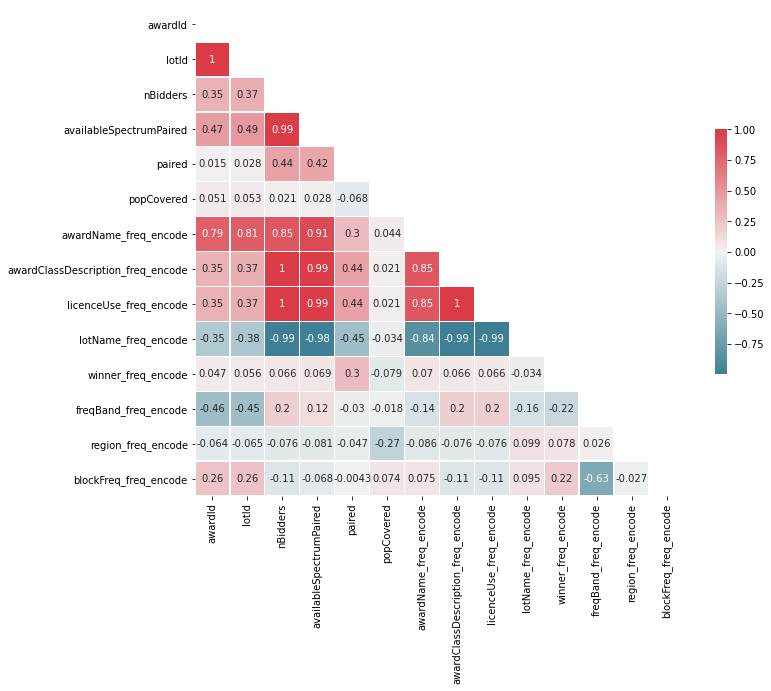

In [60]:
# Compute the correlation matrix
corr = x.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Model

In [61]:
# x has train
# y has target var
# del x['headlinePriceLocal']

train_dataset = cb.Pool(x, y)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [150, 200, 300],
        'learning_rate': [0.1],
        'depth': [8, 10, 15],
        'l2_leaf_reg': [3, 5]}
model.grid_search(grid, train_dataset)


0:	learn: 16164806364.6382828	test: 10864067884.7083206	best: 10864067884.7083206 (0)	total: 1.37ms	remaining: 204ms
1:	learn: 15613865949.8242416	test: 10516575731.7426643	best: 10516575731.7426643 (1)	total: 3.76ms	remaining: 278ms
2:	learn: 14849234201.4540863	test: 9761564227.5105324	best: 9761564227.5105324 (2)	total: 4.5ms	remaining: 220ms
3:	learn: 14148558063.5427971	test: 9111434796.7026348	best: 9111434796.7026348 (3)	total: 5.41ms	remaining: 198ms
4:	learn: 13529160502.1758232	test: 8562472499.4119043	best: 8562472499.4119043 (4)	total: 6.17ms	remaining: 179ms
5:	learn: 12985445285.8495827	test: 8209503123.8164349	best: 8209503123.8164349 (5)	total: 7.53ms	remaining: 181ms
6:	learn: 12525266915.4535389	test: 7899977180.4904585	best: 7899977180.4904585 (6)	total: 8.24ms	remaining: 168ms
7:	learn: 11973525629.8913670	test: 7485114273.1783705	best: 7485114273.1783705 (7)	total: 9.14ms	remaining: 162ms
8:	learn: 11557459309.7391090	test: 7290765886.2324486	best: 7290765886.23244

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [62]:
pred = model.predict(x)
rmse = (np.sqrt(mean_squared_error(y, pred)))
r2 = r2_score(y, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 851347931.62
R2: 1.00


Text(0.5, 0, 'CatBoost Feature Importance')

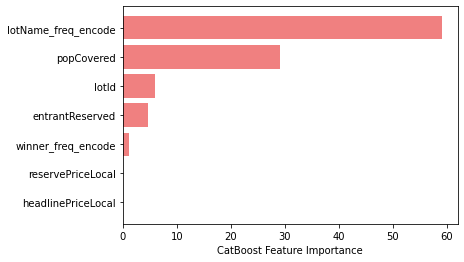

In [111]:
sorted_feature_importance = model.feature_importances_.argsort()
'''
print(type(sorted_feature_importance))
print(type(merged))
print(type(x))
print(type(y))

df = pd.DataFrame(merged.data,columns=merged.feature_names)
df['target'] = pd.Series(merged.headlinePriceLocal)
'''

plt.barh(merged.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='lightcoral')
plt.xlabel("CatBoost Feature Importance") 



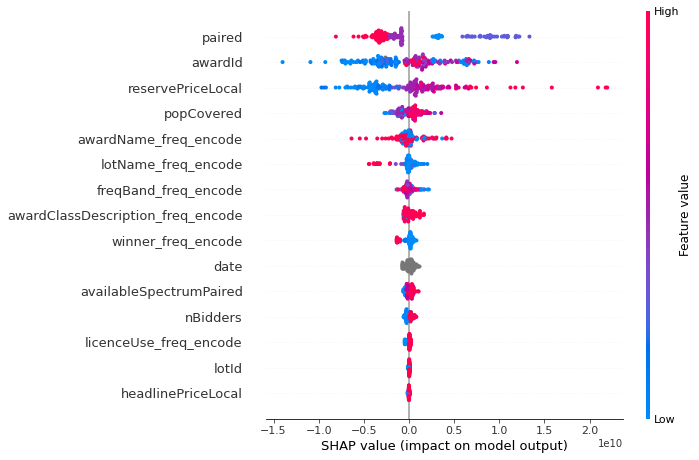

In [64]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x, feature_names = merged.columns[sorted_feature_importance])


# India 2G

In [65]:
merged = df_2G

merged

,awardId,lotId,awardName,countryName,alpha3code,nBidders,date,awardClassDescription,availableSpectrumPaired,availableSpectrumUnpaired,licenceUse,awardComments,lotName,winner,freqBand,nationalLicence,region,blockFreq,paired,unpaired,licenceDuration,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved,lotComments
12169,293,12275,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1719.20 - 1720.45 / 1814.20 - 1815.45,2.5,0.0,20.0,84665533.0,2.869100e+09,2.869100e+09,0.0,In order to receive a Unified License new entr...
12170,293,12276,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1720.45 - 1721.70 / 1815.45 - 1816.70,2.5,0.0,20.0,84665533.0,2.869100e+09,2.869100e+09,0.0,In order to receive a Unified License new entr...
12171,293,12277,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1721.70 - 1722.95 / 1816.70 - 1817.95,2.5,0.0,20.0,84665533.0,2.869100e+09,2.869100e+09,0.0,In order to receive a Unified License new entr...
12172,293,12278,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1722.95 - 1724.20 / 1817.95 - 1819.20,2.5,0.0,20.0,84665533.0,2.869100e+09,2.869100e+09,0.0,In order to receive a Unified License new entr...
12173,293,12279,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Bharti Airtel Limited,1800MHz,0,Assam,1725.10 - 1726.35 / 1820.10 - 1821.35,2.5,0.0,20.0,31169272.0,8.670000e+07,8.670000e+07,0.0,In order to receive a Unified License new entr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12266,293,12372,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Idea Cellular Ltd.,1800MHz,0,West Bengal,1723.70 - 1724.95 / 1818.70 - 1819.95,2.5,0.0,20.0,79335368.0,2.584000e+08,2.584000e+08,0.0,In order to receive a Unified License new entr...
12267,293,12373,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Idea Cellular Ltd.,1800MHz,0,West Bengal,1724.95 - 1726.20 / 1819.95 - 1821.20,2.5,0.0,20.0,79335368.0,2.584000e+08,2.584000e+08,0.0,In order to receive a Unified License new entr...
12268,293,12374,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Idea Cellular Ltd.,1800MHz,0,West Bengal,1759.60 - 1760.85 / 1854.60 - 1855.85,2.5,0.0,20.0,79335368.0,2.584000e+08,2.584000e+08,0.0,In order to receive a Unified License new entr...
12269,293,12375,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Vodafone South Limited,1800MHz,0,West Bengal,1762.10 - 1763.35 / 1857.10 - 1858.35,2.5,0.0,20.0,79335368.0,2.584000e+08,2.584000e+08,0.0,In order to receive a Unified License new entr...


In [66]:
merged['awardName'].unique()

array(['India 2G resale of quashed licences 1800MHz'], dtype=object)

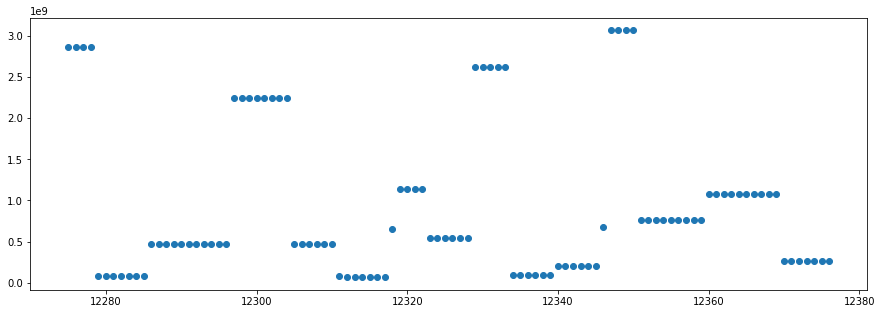

In [67]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,5))
# X axis : lotID
# Y axis : amount
plt.scatter(merged['lotId'], merged['headlinePriceLocal'])

#for i, winner in enumerate(merged['winner']):
#    plt.annotate(winner, (merged['lotId'][i], merged['headlinePriceLocal'][i]))

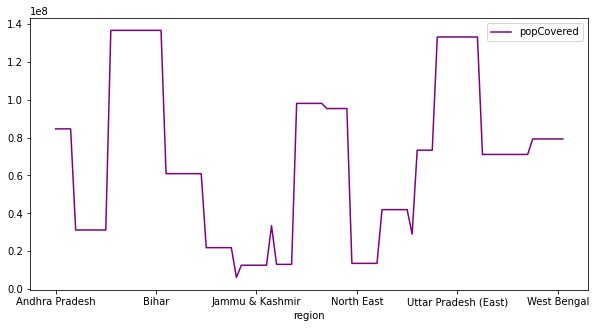

In [68]:
merged.plot(x='region', y='popCovered',figsize=(10,5),color='purple')

For each company as we have kind of 6 of them lets find out:
*   Number of wins
*   Total MOney Spend above reserved price
*   Average bids
*   Avg Winning bid over reserved 
*   Total population covered 
*   Overall population covered
*   Average population coved 
*   Regions


In [69]:
dict_for_Overall_Data = {"owner":[], "population":[], "average_population":[], "total_spend":[], "average_spend":[], "average_spend_over_reserve":[]}

In [70]:
def Get_Insights(For_Winner):
    # Prepare Variables
    Number_of_Wins = 0
    Total_Spend = int(0)
    Average_Biding_Price = 0
    Average_Biding_Price_Over_Reserved = 0
    Population_Coverd = 0
    Average_Population_Covered = 0
    Regions = set()

    for index, row in merged.iterrows():
        if row['winner'] == For_Winner:
            Number_of_Wins += 1
            Total_Spend += row['headlinePriceLocal']
            Average_Biding_Price_Over_Reserved +=  row['headlinePriceLocal'] -  row['reservePriceLocal']
            Population_Coverd += row['popCovered']
            Regions.add(row['region'])
    

    Average_Biding_Price = Total_Spend / Number_of_Wins
    Average_Biding_Price_Over_Reserved /= Number_of_Wins
    Average_Population_Covered = Population_Coverd / Number_of_Wins

    print(For_Winner)
    print("Won in ", Number_of_Wins, "  Bids") 
    print("Total Spend : ",Total_Spend)
    print("Average Bidding Price : ", round(Average_Biding_Price, 2))
    print("Average Bidding prie over Reserved : ", round(Average_Biding_Price_Over_Reserved, 2))
    print("Total population Coverd : ", Population_Coverd)
    dict_for_Overall_Data["owner"].append(For_Winner)
    dict_for_Overall_Data["population"].append(Population_Coverd)
    dict_for_Overall_Data["average_population"].append(round(Average_Population_Covered, 2))
    dict_for_Overall_Data["total_spend"].append(Total_Spend)
    dict_for_Overall_Data["average_spend"].append(round(Average_Biding_Price, 2))
    dict_for_Overall_Data["average_spend_over_reserve"].append(round(Average_Biding_Price_Over_Reserved, 2))
    print("Average Population Coverd : ", round(Average_Population_Covered, 2))
    print("Regions Coverd are : ", Regions)
    print("-----------------------------------------------------------------------------------------------------")
    #return dict_for_Population_Overall

In [71]:
# dict_for_Population_Overall = {"owner":[],"population":[]}
    
for winner in merged['winner'].unique():
    Get_Insights(winner)
    print("")

Telewings Communications Services Private Limited. 
Won in  24   Bids
Total Spend :  40182800000.0
Average Bidding Price :  1674283333.33
Average Bidding prie over Reserved :  6533333.33
Total population Coverd :  2328866412.0
Average Population Coverd :  97036100.5
Regions Coverd are :  {'Bihar', 'Maharashtra', 'Gujarat', 'Uttar Pradesh (West)', 'Andhra Pradesh', 'Uttar Pradesh (East)'}
-----------------------------------------------------------------------------------------------------

Bharti Airtel Limited 
Won in  1   Bids
Total Spend :  86700000.0
Average Bidding Price :  86700000.0
Average Bidding prie over Reserved :  0.0
Total population Coverd :  31169272.0
Average Population Coverd :  31169272.0
Regions Coverd are :  {'Assam'}
-----------------------------------------------------------------------------------------------------

Idea Cellular Ltd. 
Won in  30   Bids
Total Spend :  20345500000.0
Average Bidding Price :  678183333.33
Average Bidding prie over Reserved :  130666

In [72]:
print(dict_for_Overall_Data)

{'owner': ['Telewings Communications Services Private Limited. ', 'Bharti Airtel Limited ', 'Idea Cellular Ltd. ', 'Vodafone South Limited', 'Videocon Telecommunications Limited. ', 'Vodafone South Limited '], 'population': [2328866412.0, 31169272.0, 1275721327.0, 62338544.0, 2088409164.0, 1247620199.0], 'average_population': [97036100.5, 31169272.0, 42524044.23, 31169272.0, 87017048.5, 59410485.67], 'total_spend': [40182800000.0, 86700000.0, 20345500000.0, 173400000.0, 22214400000.0, 11106000000.0], 'average_spend': [1674283333.33, 86700000.0, 678183333.33, 86700000.0, 925600000.0, 528857142.86], 'average_spend_over_reserve': [6533333.33, 0.0, 1306666.67, 0.0, 6533333.33, 3733333.33]}


### Plots

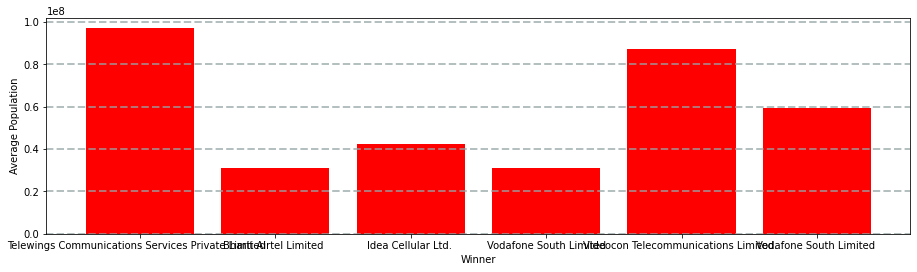

In [73]:
# Plot of Average population of each owner  
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['average_population']
ax.bar(langs,students,color='red')
plt.xlabel('Winner')
plt.ylabel('Average Population')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

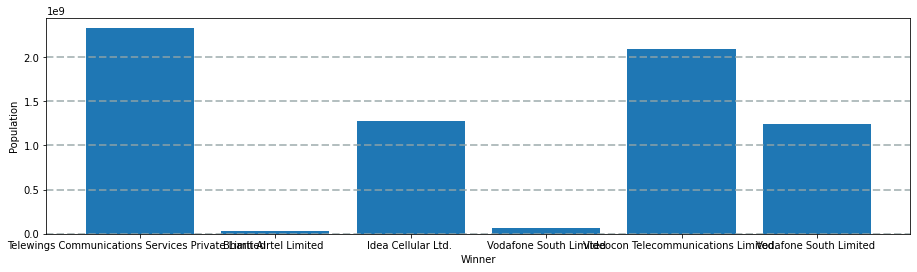

In [74]:
# Plot of Total population of each owner
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['population']
ax.bar(langs,students)
plt.xlabel('Winner')
plt.ylabel('Population')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

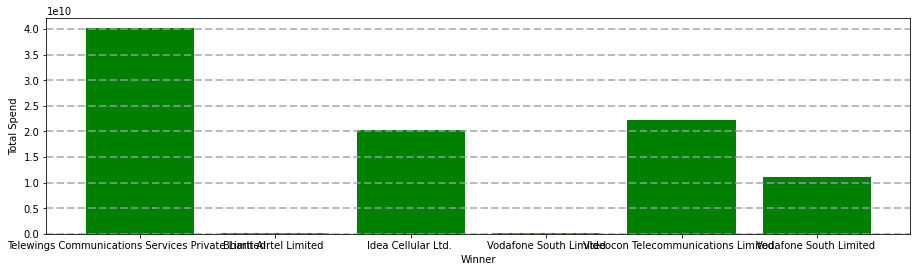

In [75]:
# Plot of total spending of each owner
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['total_spend']
ax.bar(langs,students,color='green')
plt.xlabel('Winner')
plt.ylabel('Total Spend')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

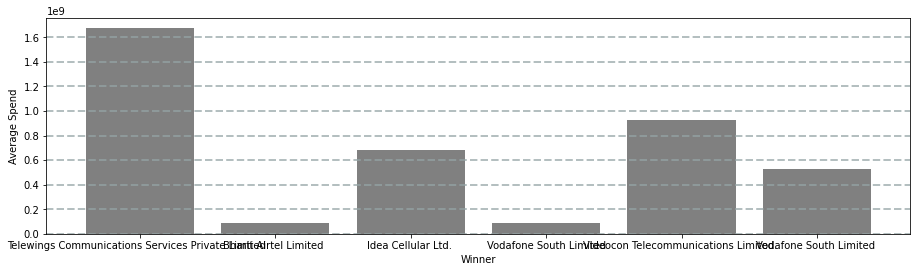

In [76]:
# plot of average spending of each ownerr  
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['average_spend']
ax.bar(langs,students,color='grey')
plt.xlabel('Winner')
plt.ylabel('Average Spend')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

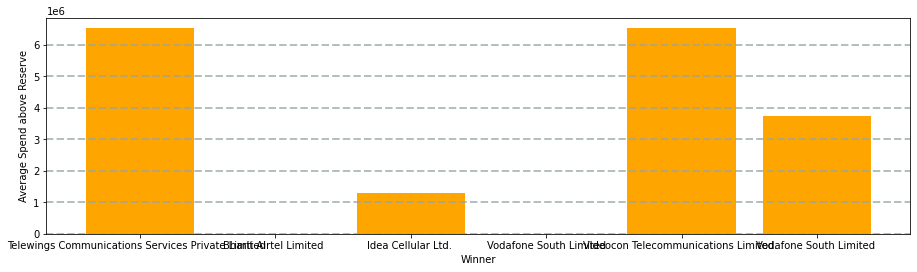

In [77]:
# plot of average spending over reserve  
fig = plt.figure(figsize=(12, 3))
ax = fig.add_axes([0,0,1,1])
langs = dict_for_Overall_Data['owner']
students = dict_for_Overall_Data['average_spend_over_reserve']
ax.bar(langs,students,color='orange')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xlabel('Winner')
plt.ylabel('Average Spend above Reserve')
plt.show()

### Making dataframe compatible

In [78]:
# Model
# Remove column name 
merged.drop(['reservePriceLocal', 'headlinePriceLocal'], axis = 1)

,awardId,lotId,awardName,countryName,alpha3code,nBidders,date,awardClassDescription,availableSpectrumPaired,availableSpectrumUnpaired,licenceUse,awardComments,lotName,winner,freqBand,nationalLicence,region,blockFreq,paired,unpaired,licenceDuration,popCovered,entrantReserved,lotComments
12169,293,12275,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1719.20 - 1720.45 / 1814.20 - 1815.45,2.5,0.0,20.0,84665533.0,0.0,In order to receive a Unified License new entr...
12170,293,12276,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1720.45 - 1721.70 / 1815.45 - 1816.70,2.5,0.0,20.0,84665533.0,0.0,In order to receive a Unified License new entr...
12171,293,12277,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1721.70 - 1722.95 / 1816.70 - 1817.95,2.5,0.0,20.0,84665533.0,0.0,In order to receive a Unified License new entr...
12172,293,12278,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Telewings Communications Services Private Limi...,1800MHz,0,Andhra Pradesh,1722.95 - 1724.20 / 1817.95 - 1819.20,2.5,0.0,20.0,84665533.0,0.0,In order to receive a Unified License new entr...
12173,293,12279,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Bharti Airtel Limited,1800MHz,0,Assam,1725.10 - 1726.35 / 1820.10 - 1821.35,2.5,0.0,20.0,31169272.0,0.0,In order to receive a Unified License new entr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12266,293,12372,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Idea Cellular Ltd.,1800MHz,0,West Bengal,1723.70 - 1724.95 / 1818.70 - 1819.95,2.5,0.0,20.0,79335368.0,0.0,In order to receive a Unified License new entr...
12267,293,12373,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Idea Cellular Ltd.,1800MHz,0,West Bengal,1724.95 - 1726.20 / 1819.95 - 1821.20,2.5,0.0,20.0,79335368.0,0.0,In order to receive a Unified License new entr...
12268,293,12374,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Idea Cellular Ltd.,1800MHz,0,West Bengal,1759.60 - 1760.85 / 1854.60 - 1855.85,2.5,0.0,20.0,79335368.0,0.0,In order to receive a Unified License new entr...
12269,293,12375,India 2G resale of quashed licences 1800MHz,India,IND,5.0,2012-11-14,Auction - Largely standard clock,590.0,0.0,mobile,There were 22 separate areas 2 of which had on...,NaN,Vodafone South Limited,1800MHz,0,West Bengal,1762.10 - 1763.35 / 1857.10 - 1858.35,2.5,0.0,20.0,79335368.0,0.0,In order to receive a Unified License new entr...


### Handling Null Values

In [79]:
# Handle Nulls
merged_cols = merged.columns.to_list()
mv = merged[merged_cols].isnull().sum()
mp = mv / len(merged)*100
mp

awardId                        0.0
lotId                          0.0
awardName                      0.0
countryName                    0.0
alpha3code                     0.0
nBidders                       0.0
date                           0.0
awardClassDescription          0.0
availableSpectrumPaired        0.0
availableSpectrumUnpaired      0.0
licenceUse                     0.0
awardComments                  0.0
lotName                      100.0
winner                         0.0
freqBand                       0.0
nationalLicence                0.0
region                         0.0
blockFreq                      0.0
paired                         0.0
unpaired                       0.0
licenceDuration                0.0
popCovered                     0.0
reservePriceLocal              0.0
headlinePriceLocal             0.0
entrantReserved                0.0
lotComments                    0.0
dtype: float64

In [80]:
# Drop columns with null values
merged = merged.drop(['lotComments', 'awardComments'], axis = 1)

In [81]:
# Delete columns which have only one or null values overall
for col in merged.columns.to_list():
    count = merged[col].nunique()
    if count == 1:
        del merged[col]
merged

,lotId,lotName,winner,region,blockFreq,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved
12169,12275,NaN,Telewings Communications Services Private Limi...,Andhra Pradesh,1719.20 - 1720.45 / 1814.20 - 1815.45,84665533.0,2.869100e+09,2.869100e+09,0.0
12170,12276,NaN,Telewings Communications Services Private Limi...,Andhra Pradesh,1720.45 - 1721.70 / 1815.45 - 1816.70,84665533.0,2.869100e+09,2.869100e+09,0.0
12171,12277,NaN,Telewings Communications Services Private Limi...,Andhra Pradesh,1721.70 - 1722.95 / 1816.70 - 1817.95,84665533.0,2.869100e+09,2.869100e+09,0.0
12172,12278,NaN,Telewings Communications Services Private Limi...,Andhra Pradesh,1722.95 - 1724.20 / 1817.95 - 1819.20,84665533.0,2.869100e+09,2.869100e+09,0.0
12173,12279,NaN,Bharti Airtel Limited,Assam,1725.10 - 1726.35 / 1820.10 - 1821.35,31169272.0,8.670000e+07,8.670000e+07,0.0
...,...,...,...,...,...,...,...,...,...
12266,12372,NaN,Idea Cellular Ltd.,West Bengal,1723.70 - 1724.95 / 1818.70 - 1819.95,79335368.0,2.584000e+08,2.584000e+08,0.0
12267,12373,NaN,Idea Cellular Ltd.,West Bengal,1724.95 - 1726.20 / 1819.95 - 1821.20,79335368.0,2.584000e+08,2.584000e+08,0.0
12268,12374,NaN,Idea Cellular Ltd.,West Bengal,1759.60 - 1760.85 / 1854.60 - 1855.85,79335368.0,2.584000e+08,2.584000e+08,0.0
12269,12375,NaN,Vodafone South Limited,West Bengal,1762.10 - 1763.35 / 1857.10 - 1858.35,79335368.0,2.584000e+08,2.584000e+08,0.0


In [82]:
'''
# Label Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

merged['lotName'] = LabelEncoder().fit_transform(merged.lotName)
merged['winner'] = LabelEncoder().fit_transform(merged.winner)
merged['region'] = LabelEncoder().fit_transform(merged.region)
merged['blockFreq'] = LabelEncoder().fit_transform(merged.blockFreq)

merged
# One Hot Encoding
ohc = OneHotEncoder()
ohe = ohc.fit_transform(merged.winner.value.reshape(-1, 1)).to_array()
mergedOHE = pd.Dataframe(ohe, columns = ["Winner_" +str(ohc.categories[0][i])
                                                    for i in range(len(ohc.categories_[0]))])
mergedOHE = pd.concat([merged, mergedOHE], axis = 1)
merged
'''

'\n# Label Encoding\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.preprocessing import OneHotEncoder\n\nmerged[\'lotName\'] = LabelEncoder().fit_transform(merged.lotName)\nmerged[\'winner\'] = LabelEncoder().fit_transform(merged.winner)\nmerged[\'region\'] = LabelEncoder().fit_transform(merged.region)\nmerged[\'blockFreq\'] = LabelEncoder().fit_transform(merged.blockFreq)\n\nmerged\n# One Hot Encoding\nohc = OneHotEncoder()\nohe = ohc.fit_transform(merged.winner.value.reshape(-1, 1)).to_array()\nmergedOHE = pd.Dataframe(ohe, columns = ["Winner_" +str(ohc.categories[0][i])\n                                                    for i in range(len(ohc.categories_[0]))])\nmergedOHE = pd.concat([merged, mergedOHE], axis = 1)\nmerged\n'

In [83]:
t = merged.corr()
t 

,lotId,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved
lotId,1.000000,0.083818,-0.064788,-0.070277,0.039624
popCovered,0.083818,1.000000,0.195187,0.202929,0.267370
reservePriceLocal,-0.064788,0.195187,1.000000,0.999917,-0.059370
headlinePriceLocal,-0.070277,0.202929,0.999917,1.000000,-0.055367
entrantReserved,0.039624,0.267370,-0.059370,-0.055367,1.000000


In [84]:
# Frequency Encoding
def Frequency_Encode(col):
    # print(col)
    fe = merged.groupby(col).size() / len(merged)
    merged.loc[:, col + '_freq_encode'] = merged[col].map(fe)
    merged

for col in merged.columns.to_list():
    # print(col, type(merged[col]))
    if merged[col].dtype == 'object':
        Frequency_Encode(col)
        del merged[col]

merged

,lotId,popCovered,reservePriceLocal,headlinePriceLocal,entrantReserved,lotName_freq_encode,winner_freq_encode,region_freq_encode,blockFreq_freq_encode
12169,12275,84665533.0,2.869100e+09,2.869100e+09,0.0,NaN,0.235294,0.039216,0.019608
12170,12276,84665533.0,2.869100e+09,2.869100e+09,0.0,NaN,0.235294,0.039216,0.009804
12171,12277,84665533.0,2.869100e+09,2.869100e+09,0.0,NaN,0.235294,0.039216,0.009804
12172,12278,84665533.0,2.869100e+09,2.869100e+09,0.0,NaN,0.235294,0.039216,0.019608
12173,12279,31169272.0,8.670000e+07,8.670000e+07,0.0,NaN,0.009804,0.068627,0.009804
...,...,...,...,...,...,...,...,...,...
12266,12372,79335368.0,2.584000e+08,2.584000e+08,0.0,NaN,0.294118,0.068627,0.009804
12267,12373,79335368.0,2.584000e+08,2.584000e+08,0.0,NaN,0.294118,0.068627,0.009804
12268,12374,79335368.0,2.584000e+08,2.584000e+08,0.0,NaN,0.294118,0.068627,0.009804
12269,12375,79335368.0,2.584000e+08,2.584000e+08,0.0,NaN,0.205882,0.068627,0.009804


In [85]:
x = merged.copy()
del x['reservePriceLocal']
del x['headlinePriceLocal']
y = pd.DataFrame(merged.headlinePriceLocal)
x

,lotId,popCovered,entrantReserved,lotName_freq_encode,winner_freq_encode,region_freq_encode,blockFreq_freq_encode
12169,12275,84665533.0,0.0,NaN,0.235294,0.039216,0.019608
12170,12276,84665533.0,0.0,NaN,0.235294,0.039216,0.009804
12171,12277,84665533.0,0.0,NaN,0.235294,0.039216,0.009804
12172,12278,84665533.0,0.0,NaN,0.235294,0.039216,0.019608
12173,12279,31169272.0,0.0,NaN,0.009804,0.068627,0.009804
...,...,...,...,...,...,...,...
12266,12372,79335368.0,0.0,NaN,0.294118,0.068627,0.009804
12267,12373,79335368.0,0.0,NaN,0.294118,0.068627,0.009804
12268,12374,79335368.0,0.0,NaN,0.294118,0.068627,0.009804
12269,12375,79335368.0,0.0,NaN,0.205882,0.068627,0.009804


In [86]:
y

,headlinePriceLocal
12169,2.869100e+09
12170,2.869100e+09
12171,2.869100e+09
12172,2.869100e+09
12173,8.670000e+07
...,...
12266,2.584000e+08
12267,2.584000e+08
12268,2.584000e+08
12269,2.584000e+08


In [87]:
print(x.shape, y.shape)

(102, 7) (102, 1)


### Correlation Matrix

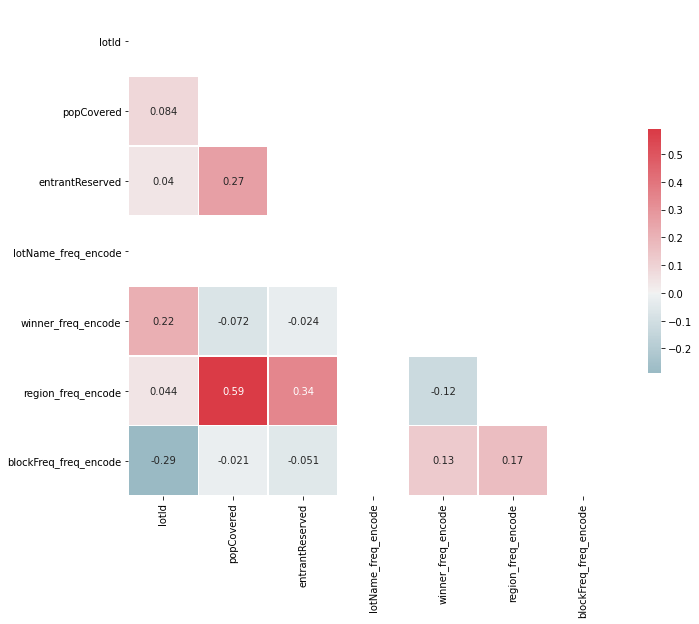

In [88]:
# Compute the correlation matrix
corr = x.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Model

In [89]:
## x has train
# y has target var
# del x['headlinePriceLocal']

train_dataset = cb.Pool(x, y)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [150, 200, 300],
        'learning_rate': [0.1],
        'depth': [8, 10, 15],
        'l2_leaf_reg': [3, 5]}
model.grid_search(grid, train_dataset)


0:	learn: 1323235432.8721907	test: 893734894.5590547	best: 893734894.5590547 (0)	total: 491us	remaining: 73.2ms
1:	learn: 1236989112.2136540	test: 829447864.9482455	best: 829447864.9482455 (1)	total: 1.65ms	remaining: 122ms
2:	learn: 1168831409.0971591	test: 777696174.9415655	best: 777696174.9415655 (2)	total: 2.39ms	remaining: 117ms
3:	learn: 1104727811.4748378	test: 727792522.3984749	best: 727792522.3984749 (3)	total: 3.31ms	remaining: 121ms
4:	learn: 1045179262.3293995	test: 683637729.7741860	best: 683637729.7741860 (4)	total: 3.88ms	remaining: 113ms
5:	learn: 1003573537.5510668	test: 652317332.7023299	best: 652317332.7023299 (5)	total: 4.62ms	remaining: 111ms
6:	learn: 949428853.6844401	test: 622315036.9236509	best: 622315036.9236509 (6)	total: 5.55ms	remaining: 113ms
7:	learn: 885622432.6941608	test: 582286532.9060403	best: 582286532.9060403 (7)	total: 6.26ms	remaining: 111ms
8:	learn: 829920215.0922205	test: 546539183.2440990	best: 546539183.2440990 (8)	total: 7.14ms	remaining: 1

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [90]:
pred = model.predict(x)
rmse = (np.sqrt(mean_squared_error(y, pred)))
r2 = r2_score(y, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 2458385.51
R2: 1.00


Text(0.5, 0, 'CatBoost Feature Importance')

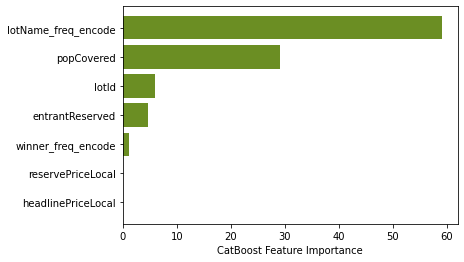

In [113]:
sorted_feature_importance = model.feature_importances_.argsort()
'''
print(type(sorted_feature_importance))
print(type(merged))
print(type(x))
print(type(y))

df = pd.DataFrame(merged.data,columns=merged.feature_names)
df['target'] = pd.Series(merged.headlinePriceLocal)
'''

plt.barh(merged.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='olivedrab')
plt.xlabel("CatBoost Feature Importance") 



All-NaN slice encountered


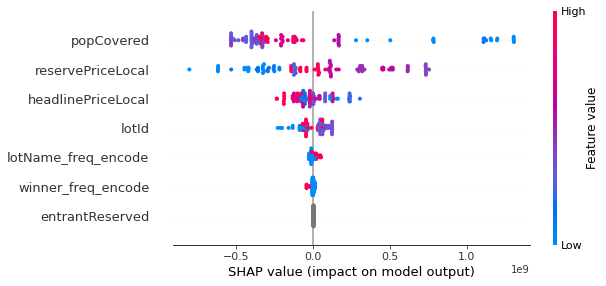

In [92]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x, feature_names = merged.columns[sorted_feature_importance])
